In [1]:
import numpy as np
import pandas as pd  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import mean_squared_error, mean_absolute_error , mean_absolute_percentage_error
import matplotlib.pyplot as plt


Part 1

In [2]:
# Load dataset
train_df = pd.read_csv('/Users/hanyfaltaos/Downloads/Neuoral 24-25/train.csv')

# Check for missing values
print("Missing values per column:\n", train_df.isnull().sum())

# Handle missing values
if train_df.isnull().sum().sum() > 0:  # Check if there are any missing values
    # Fill missing values with column median
    train_df = train_df.fillna(train_df.median())
    print("Missing values handled by imputation (median substitution).")
else:
    print("No missing values found.")

# Define input (X) and target (y) features
input_features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
X = train_df[input_features]
y = train_df['MedHouseVal']

# Normalize input features for neural network training
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Normalize the target feature using MinMaxScaler
y_scaler = MinMaxScaler()
y_normalized = y_scaler.fit_transform(y.values.reshape(-1, 1))

# Split data into 80% for training/validation and 20% for testing
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_normalized, y_normalized, test_size=0.2, random_state=42, shuffle=True
)

# Further split training/validation data into 75% training and 25% validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, shuffle=True
)

# Print the number of records in each set
print(f"Training Data: {len(X_train)} records")
print(f"Validation Data: {len(X_val)} records")
print(f"Testing Data: {len(X_test)} records")

print("Data preprocessing and splitting completed!")

Missing values per column:
 id             0
MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64
No missing values found.
Training Data: 22281 records
Validation Data: 7428 records
Testing Data: 7428 records
Data preprocessing and splitting completed!


Part 2

Epoch 1/50, Training Loss: 0.3400907808699488, Validation Loss: 0.3380084941174952
Epoch 2/50, Training Loss: 0.32061577231546246, Validation Loss: 0.3183203325742085
Epoch 3/50, Training Loss: 0.2932406167676587, Validation Loss: 0.2907092001825908
Epoch 4/50, Training Loss: 0.2548258405694268, Validation Loss: 0.2520768948846005
Epoch 5/50, Training Loss: 0.20545285135266447, Validation Loss: 0.2026047528756303
Epoch 6/50, Training Loss: 0.152291518192891, Validation Loss: 0.1495597825420496
Epoch 7/50, Training Loss: 0.1096436410030711, Validation Loss: 0.10719079455452382
Epoch 8/50, Training Loss: 0.08335432515194613, Validation Loss: 0.08118486649983167
Epoch 9/50, Training Loss: 0.06964422955175248, Validation Loss: 0.06768224794629651
Epoch 10/50, Training Loss: 0.06308460606463524, Validation Loss: 0.06125497679652797
Epoch 11/50, Training Loss: 0.0600277183154464, Validation Loss: 0.05827948685341718
Epoch 12/50, Training Loss: 0.058596682372522045, Validation Loss: 0.0568990

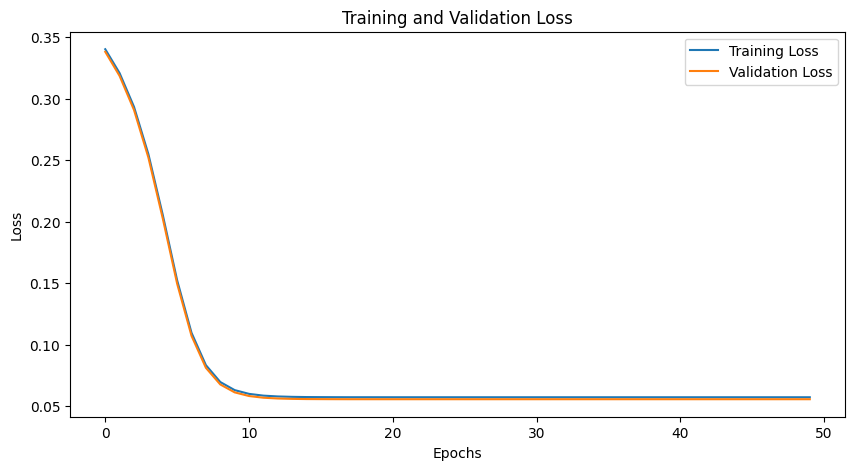

In [3]:
# Part 2: Neural Network Implementation from Scratch

class NeuralNet:
    def __init__(self, layers, epochs, learning_rate, momentum, activation='relu', val_split=0.2):
        self.L = len(layers)  # Number of layers
        self.n = layers  # Number of units in each layer
        self.epochs = epochs
        self.lr = learning_rate
        self.momentum = momentum
        self.activation_name = activation
        self.val_split = val_split

        # Initialize weights and thresholds using Xavier initialization
        self.w = [None] + [np.random.randn(self.n[l], self.n[l - 1]) * np.sqrt(2 / (self.n[l] + self.n[l - 1])) for l in range(1, self.L)]
        self.theta = [None] + [np.random.randn(self.n[l]) * np.sqrt(2 / self.n[l]) for l in range(1, self.L)]

        # Initialize previous weight changes for momentum
        self.d_w_prev = [None] + [np.zeros_like(self.w[l]) for l in range(1, self.L)]
        self.d_theta_prev = [None] + [np.zeros_like(self.theta[l]) for l in range(1, self.L)]

        # Initialize activations, fields, and deltas
        self.xi = [None] * self.L  # Array to hold activations for each layer
        self.h = [None] * self.L  # Array to hold the weighted sums before activation
        self.delta = [None] * self.L  # Array to hold error propagation terms for each layer

    def activation(self, x):
        if self.activation_name == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation_name == 'relu':
            return np.maximum(0, x)
        elif self.activation_name == 'tanh':
            return np.tanh(x)
        elif self.activation_name == 'linear':
            return x

    def activation_derivative(self, x):
        if self.activation_name == 'sigmoid':
            return x * (1 - x)
        elif self.activation_name == 'relu':
            return np.where(x > 0, 1, 0)
        elif self.activation_name == 'tanh':
            return 1 - np.tanh(x) ** 2
        elif self.activation_name == 'linear':
            return np.ones_like(x)

    def feed_forward(self, x):
        x = np.array(x, dtype=float)  # Ensure input is a numpy array of floats
        self.xi[0] = x # Set input features as activations for the first layer
        for l in range(1, self.L): # For each layer from 1 to L
            self.h[l] = np.dot(self.w[l], self.xi[l - 1]) - self.theta[l] # Weighted sum
            self.xi[l] = self.activation(self.h[l])  # Apply activation function
        return self.xi # Return the output of the last layer (prediction)

    def back_propagate(self, y):
        # Calculate deltas and update weights/thresholds
        self.delta[-1] = self.activation_derivative(self.xi[-1]) * (self.xi[-1] - y)
        
        # Back-propagate delta to hidden layers
        for l in reversed(range(1, self.L - 1)):
            self.delta[l] = self.activation_derivative(self.xi[l]) * np.dot(self.w[l + 1].T, self.delta[l + 1])

        # Update weights and thresholds using deltas
        for l in range(1, self.L):
            d_w = -self.lr * np.outer(self.delta[l], self.xi[l - 1]) + self.momentum * self.d_w_prev[l]
            d_theta = self.lr * self.delta[l] + self.momentum * self.d_theta_prev[l]
            self.w[l] += d_w
            self.theta[l] += d_theta
            self.d_w_prev[l], self.d_theta_prev[l] = d_w, d_theta

    def fit(self, X, y, X_val=None, y_val=None):
        train_loss = []
        val_loss = []

        for epoch in range(self.epochs):
            for i in range(len(X)):
                # Choose a random pattern for online training
                idx = np.random.randint(0, len(X))
                x_mu, y_mu = np.array(X)[idx], np.array(y)[idx]

                # Feed-forward and back-propagate
                self.feed_forward(x_mu)
                self.back_propagate(y_mu)

            # Calculate training loss for the current epoch
            train_predictions = self.predict(np.array(X, dtype=float))
            train_loss.append(np.mean((train_predictions - np.array(y, dtype=float)) ** 2))

            # Calculate validation loss if validation data is provided
            if X_val is not None and y_val is not None:
                val_predictions = self.predict(np.array(X_val, dtype=float))
                val_loss.append(np.mean((val_predictions - np.array(y_val, dtype=float)) ** 2))

            # Print loss for each epoch to monitor training
            print(f"Epoch {epoch + 1}/{self.epochs}, Training Loss: {train_loss[-1]}, Validation Loss: {val_loss[-1] if val_loss else 'N/A'}")

        return train_loss, val_loss

    def predict(self, X):
        X = np.array(X, dtype=float)  # Ensure input is a numpy array of floats
        predictions = []
        for x in X:
            self.feed_forward(x)
            predictions.append(self.xi[-1])
        return np.array(predictions)

    def loss_epochs(self, X_train, y_train, X_val, y_val):
        train_loss = []
        val_loss = []
        for epoch in range(self.epochs):
            train_predictions = self.predict(X_train)
            val_predictions = self.predict(X_val)

            train_loss.append(np.mean((train_predictions - y_train) ** 2))
            val_loss.append(np.mean((val_predictions - y_val) ** 2))
        return train_loss, val_loss

# Plotting Training and Validation Loss
def plot_loss(train_loss, val_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Training Loss')
    if val_loss:
        plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

# Normalize Input Features for Training, Validation, and Testing
X_train_scaled = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_val_scaled = (X_val - X_val.min()) / (X_val.max() - X_val.min())
X_test_scaled = (X_test - X_test.min()) / (X_test.max() - X_test.min())

# Initialize and Train the Neural Network
nn_test = NeuralNet(
    layers=[8, 9, 5, 1],  # Architecture: 8 input features, 2 hidden layers, 1 output
    epochs=50,  # Number of epochs
    learning_rate=0.00001,  # Learning rate
    momentum=0.9,  # Momentum term
    activation='sigmoid',  # Activation function
    val_split=0.2  # Validation split is handled externally
)

train_loss, val_loss = nn_test.fit(
    X_train_scaled, y_train, X_val_scaled, y_val
)

# Evaluate on Test Data
test_predictions = nn_test.predict(X_test_scaled)
test_loss = np.mean((test_predictions - y_test) ** 2)
print(f"Test Loss: {test_loss}")

# Plot Training and Validation Loss
plot_loss(train_loss, val_loss)


Part 3.1

Evaluating Set 1 - Layers: [8, 9, 1], Learning Rate: 0.0001, Momentum: 0.5, Activation: sigmoid


Epoch 1/50, Training Loss: 0.05689091741793827, Validation Loss: 0.059711822657981785
Epoch 2/50, Training Loss: 0.056623934536716096, Validation Loss: 0.05933053451772319
Epoch 3/50, Training Loss: 0.05659275166247815, Validation Loss: 0.05926815722446057
Epoch 4/50, Training Loss: 0.05658056270218509, Validation Loss: 0.05923057828112563
Epoch 5/50, Training Loss: 0.05658096692181117, Validation Loss: 0.05923272328212726
Epoch 6/50, Training Loss: 0.05657965435494282, Validation Loss: 0.059225818432599386
Epoch 7/50, Training Loss: 0.05658023912767346, Validation Loss: 0.05922952907041787
Epoch 8/50, Training Loss: 0.05657940513295248, Validation Loss: 0.05920753587413958
Epoch 9/50, Training Loss: 0.0565787067535301, Validation Loss: 0.05921372627528682
Epoch 10/50, Training Loss: 0.056578651202545543, Validation Loss: 0.05921387362652706
Epoch 11/50, Training Loss: 0.05657858692303006, Validation Loss: 0.05921623524250716
Epoch 12/50, Training Loss: 0.05658023487519525, Validation 

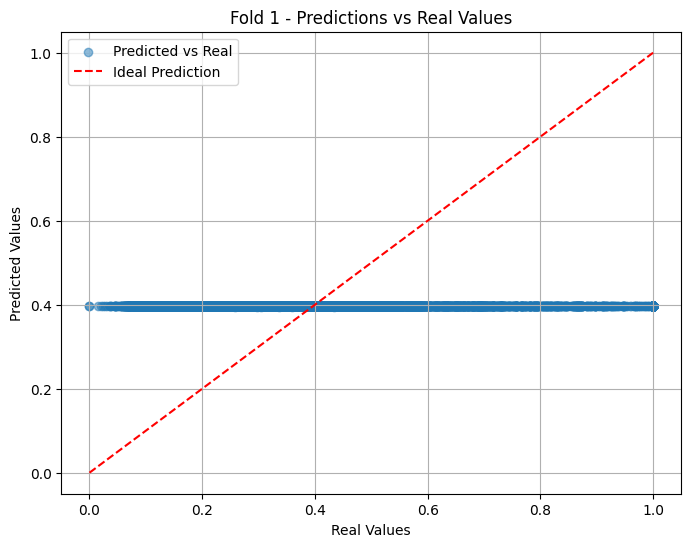

Epoch 1/50, Training Loss: 0.20162888975269302, Validation Loss: 0.19761434819986362
Epoch 2/50, Training Loss: 0.2002753891227153, Validation Loss: 0.1962747038479834
Epoch 3/50, Training Loss: 0.1986659793296234, Validation Loss: 0.19468185540781208
Epoch 4/50, Training Loss: 0.19671486834119448, Validation Loss: 0.19275094820332966
Epoch 5/50, Training Loss: 0.19433689308858113, Validation Loss: 0.1903977877694806
Epoch 6/50, Training Loss: 0.19136192391160944, Validation Loss: 0.18745416603775114
Epoch 7/50, Training Loss: 0.18759849860106526, Validation Loss: 0.1837308945042539
Epoch 8/50, Training Loss: 0.18262628599576566, Validation Loss: 0.17881262437447024
Epoch 9/50, Training Loss: 0.17592407713680125, Validation Loss: 0.1721848319400106
Epoch 10/50, Training Loss: 0.1666016830424757, Validation Loss: 0.16296949805017577
Epoch 11/50, Training Loss: 0.15324808215690863, Validation Loss: 0.14977746490777452
Epoch 12/50, Training Loss: 0.1346300424494982, Validation Loss: 0.131

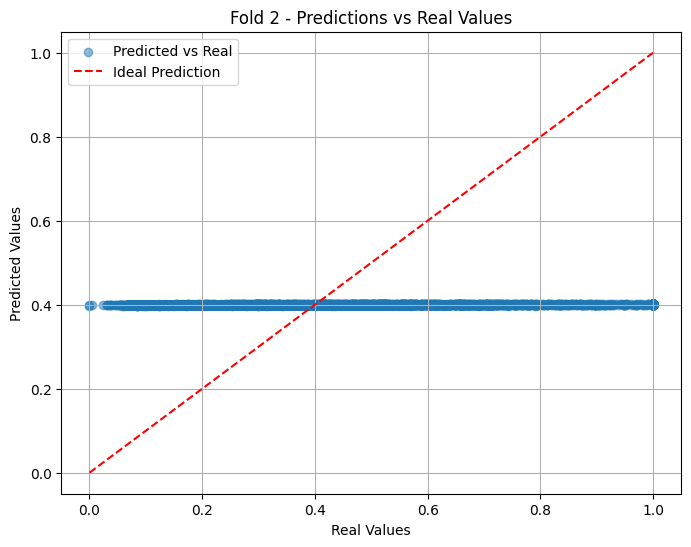

Epoch 1/50, Training Loss: 0.059746119059527154, Validation Loss: 0.058224237313234145
Epoch 2/50, Training Loss: 0.058292341619129315, Validation Loss: 0.05688087109668508
Epoch 3/50, Training Loss: 0.05779237261786815, Validation Loss: 0.05644880089700633
Epoch 4/50, Training Loss: 0.05766800638979052, Validation Loss: 0.05635413053538223
Epoch 5/50, Training Loss: 0.057592779193190675, Validation Loss: 0.0563166974707286
Epoch 6/50, Training Loss: 0.05758856154016678, Validation Loss: 0.056321259894545755
Epoch 7/50, Training Loss: 0.05758836660314586, Validation Loss: 0.05632603060053574
Epoch 8/50, Training Loss: 0.05758830458997277, Validation Loss: 0.05632167699895283
Epoch 9/50, Training Loss: 0.05758893016893868, Validation Loss: 0.05631937057094692
Epoch 10/50, Training Loss: 0.057588192355220474, Validation Loss: 0.05632135441535509
Epoch 11/50, Training Loss: 0.05759037028228936, Validation Loss: 0.056317272075414974
Epoch 12/50, Training Loss: 0.05758787601999586, Validati

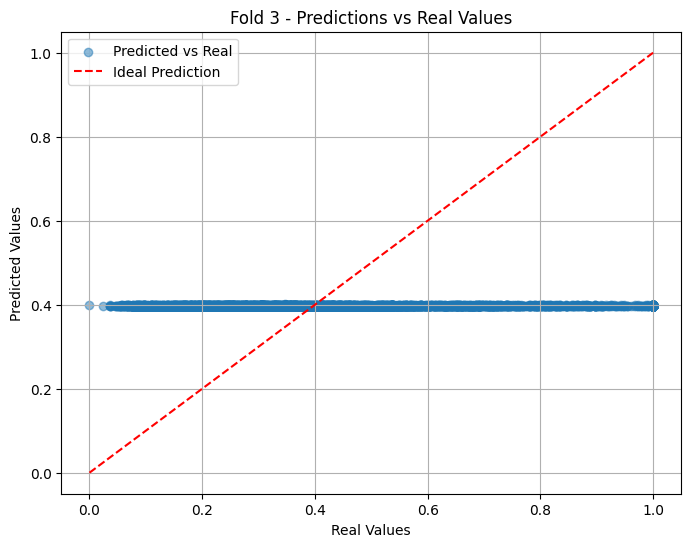

Epoch 1/50, Training Loss: 0.11638868421769005, Validation Loss: 0.11683384668981346
Epoch 2/50, Training Loss: 0.0944512485015788, Validation Loss: 0.09474719203523996
Epoch 3/50, Training Loss: 0.075841837241982, Validation Loss: 0.07597098629650918
Epoch 4/50, Training Loss: 0.06479054942909851, Validation Loss: 0.06477406396508971
Epoch 5/50, Training Loss: 0.05991546243839284, Validation Loss: 0.059795269378218954
Epoch 6/50, Training Loss: 0.05815910065218503, Validation Loss: 0.057974834940134085
Epoch 7/50, Training Loss: 0.057544693073021985, Validation Loss: 0.057319812327282976
Epoch 8/50, Training Loss: 0.057402340355349614, Validation Loss: 0.05716040241035675
Epoch 9/50, Training Loss: 0.05733895095312218, Validation Loss: 0.057083734685641256
Epoch 10/50, Training Loss: 0.0573266381485781, Validation Loss: 0.05706682130928047
Epoch 11/50, Training Loss: 0.057319403942364136, Validation Loss: 0.05705507133970344
Epoch 12/50, Training Loss: 0.05732196059901352, Validation 

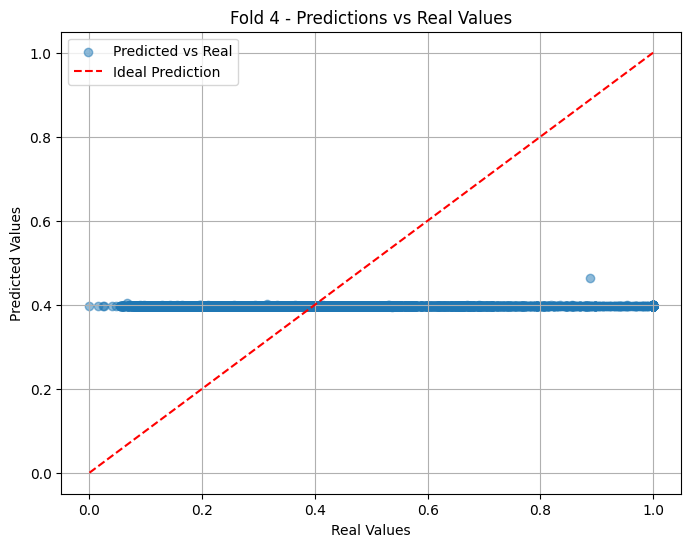

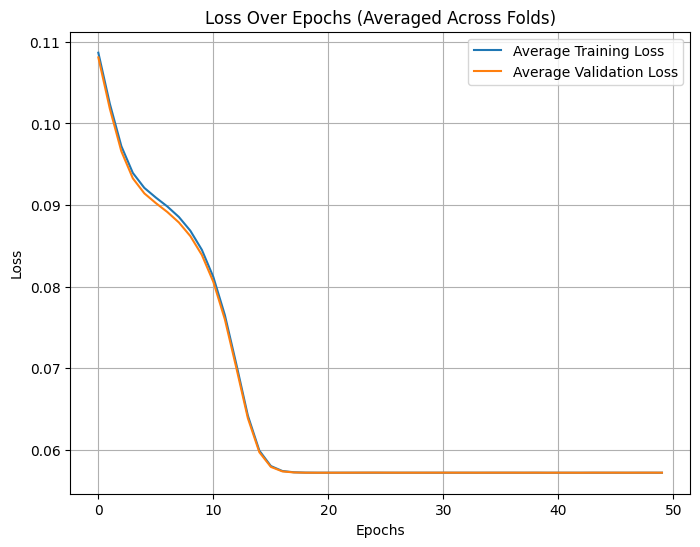

Evaluating Set 2 - Layers: [8, 12, 1], Learning Rate: 0.01, Momentum: 0.9, Activation: relu
Epoch 1/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 2/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 3/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 4/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 5/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 6/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 7/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 8/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 9/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 10/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 11/50, Training Loss: 0.2137425760605977, Validation Loss: 0.

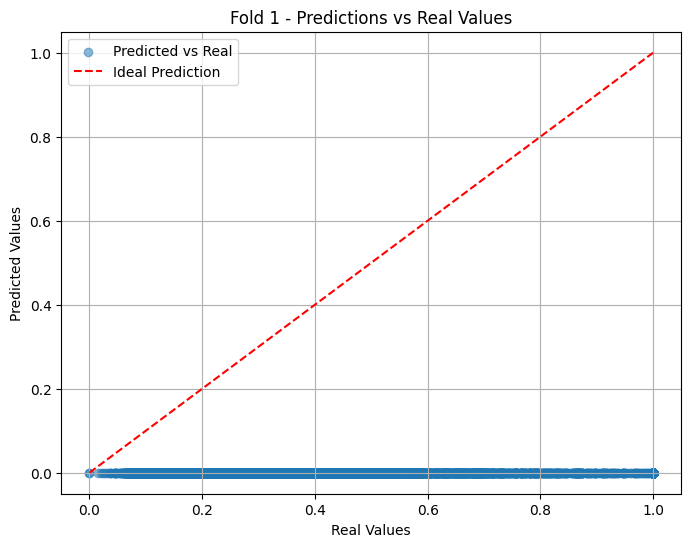

Epoch 1/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 2/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 3/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 4/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 5/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 6/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 7/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 8/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 9/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 10/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 11/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 12/50, Training Loss: 0.2164758905139149, Validation Loss: 0.2123134

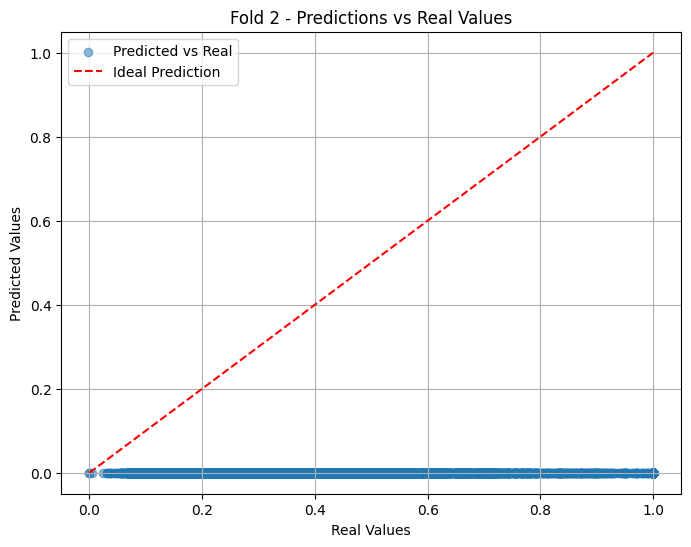

Epoch 1/50, Training Loss: 0.06663973923527866, Validation Loss: 0.0648322491740386
Epoch 2/50, Training Loss: 0.06123305529712973, Validation Loss: 0.06029718290074733
Epoch 3/50, Training Loss: 0.05759430909122192, Validation Loss: 0.05627970587075897
Epoch 4/50, Training Loss: 0.05899150529434999, Validation Loss: 0.057934346231885786
Epoch 5/50, Training Loss: 0.057148438200010046, Validation Loss: 0.05586747710568126
Epoch 6/50, Training Loss: 0.0639438588350176, Validation Loss: 0.06212812562393849
Epoch 7/50, Training Loss: 0.05801620646140608, Validation Loss: 0.05630720531044488
Epoch 8/50, Training Loss: 0.059238187251825586, Validation Loss: 0.05773628768385695
Epoch 9/50, Training Loss: 0.059190735193445795, Validation Loss: 0.05770808307216715
Epoch 10/50, Training Loss: 0.057768000478696166, Validation Loss: 0.05643711660706934
Epoch 11/50, Training Loss: 0.06163302982993167, Validation Loss: 0.0607289182114515
Epoch 12/50, Training Loss: 0.06153803521211327, Validation L

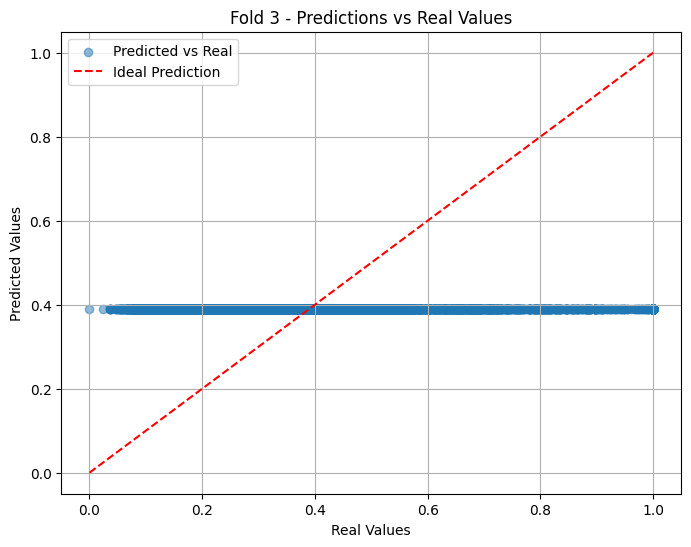

Epoch 1/50, Training Loss: 0.05713238917120421, Validation Loss: 0.056873869091971736
Epoch 2/50, Training Loss: 0.05673007217540269, Validation Loss: 0.05645974111117196
Epoch 3/50, Training Loss: 0.06909538770701995, Validation Loss: 0.06854888225775863
Epoch 4/50, Training Loss: 0.05791859178039486, Validation Loss: 0.057769516351043305
Epoch 5/50, Training Loss: 0.06449766294235273, Validation Loss: 0.06402236386867756
Epoch 6/50, Training Loss: 0.057376259858628785, Validation Loss: 0.05717715798843846
Epoch 7/50, Training Loss: 0.06634124516405833, Validation Loss: 0.06583688261808542
Epoch 8/50, Training Loss: 0.058113537595521875, Validation Loss: 0.05797756866323262
Epoch 9/50, Training Loss: 0.06874342749602336, Validation Loss: 0.06820324903976371
Epoch 10/50, Training Loss: 0.06408478647310653, Validation Loss: 0.06411228048001841
Epoch 11/50, Training Loss: 0.058349008692641424, Validation Loss: 0.05803452454570502
Epoch 12/50, Training Loss: 0.0607799348087915, Validation

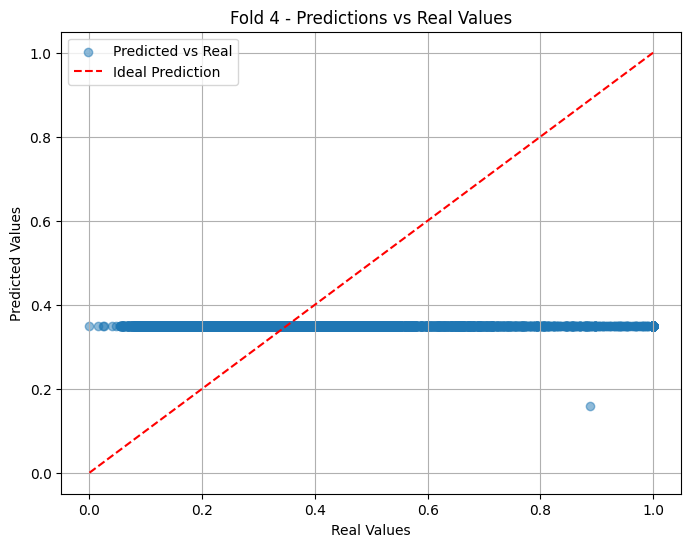

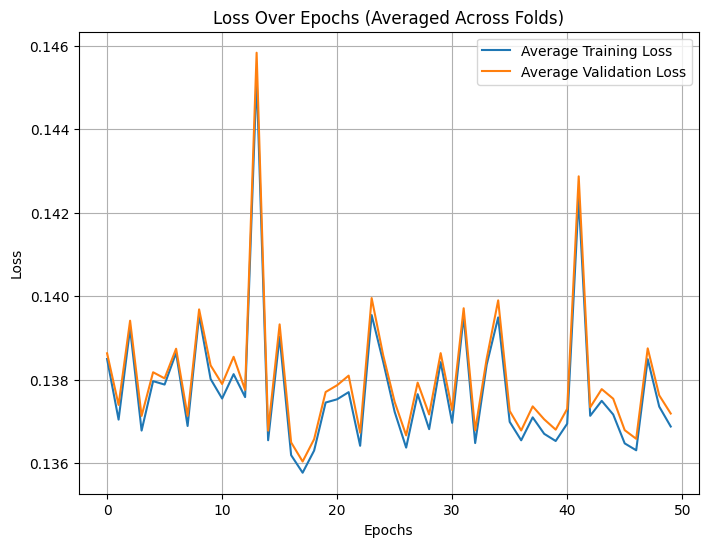

Evaluating Set 3 - Layers: [8, 10, 5, 1], Learning Rate: 0.01, Momentum: 0.9, Activation: tanh
Epoch 1/50, Training Loss: 0.05941077661265779, Validation Loss: 0.061441502936386325
Epoch 2/50, Training Loss: 0.05544777558076978, Validation Loss: 0.05801303095349207
Epoch 3/50, Training Loss: 0.054506729335820625, Validation Loss: 0.05683509260072338
Epoch 4/50, Training Loss: 0.050800960082996886, Validation Loss: 0.05305998772928992
Epoch 5/50, Training Loss: 0.04541920197076697, Validation Loss: 0.04734734332218168
Epoch 6/50, Training Loss: 0.0439580638214449, Validation Loss: 0.04579463623236685
Epoch 7/50, Training Loss: 0.046386328611878004, Validation Loss: 0.04770125759833475
Epoch 8/50, Training Loss: 0.03916015013319071, Validation Loss: 0.04155950455910529
Epoch 9/50, Training Loss: 0.035276047152624015, Validation Loss: 0.03739723841398873
Epoch 10/50, Training Loss: 0.05076586681662442, Validation Loss: 0.05334200750484393
Epoch 11/50, Training Loss: 0.0326322530781654, Va

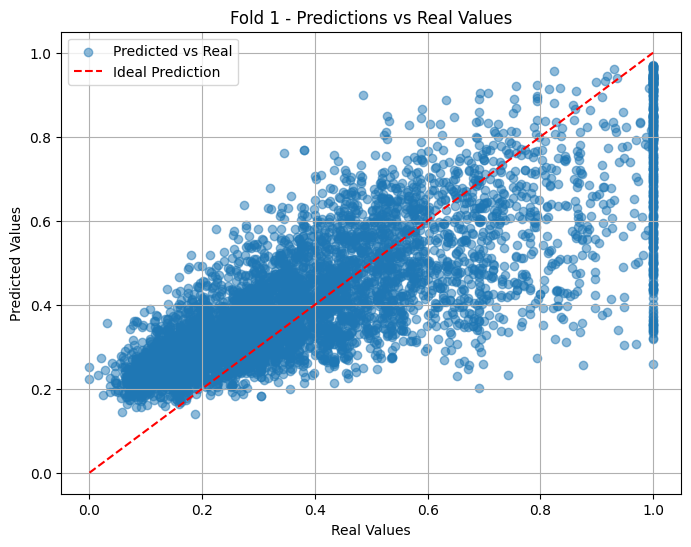

Epoch 1/50, Training Loss: 0.05738816101805397, Validation Loss: 0.05630400039285998
Epoch 2/50, Training Loss: 0.06007823881507239, Validation Loss: 0.059415545828953725
Epoch 3/50, Training Loss: 0.06000856070272481, Validation Loss: 0.05855291756910815
Epoch 4/50, Training Loss: 0.058705842752223764, Validation Loss: 0.05735275618782049
Epoch 5/50, Training Loss: 0.07109425222228018, Validation Loss: 0.0711650517287334
Epoch 6/50, Training Loss: 0.05477690212422966, Validation Loss: 0.053940152893935514
Epoch 7/50, Training Loss: 0.05257197875663204, Validation Loss: 0.05261676501758653
Epoch 8/50, Training Loss: 0.04204426247573134, Validation Loss: 0.042083557269517596
Epoch 9/50, Training Loss: 0.03249117936657739, Validation Loss: 0.03261315788905923
Epoch 10/50, Training Loss: 0.04850513031408103, Validation Loss: 0.048492411712900134
Epoch 11/50, Training Loss: 0.033213426970669986, Validation Loss: 0.03338435858520551
Epoch 12/50, Training Loss: 0.030154343071711442, Validati

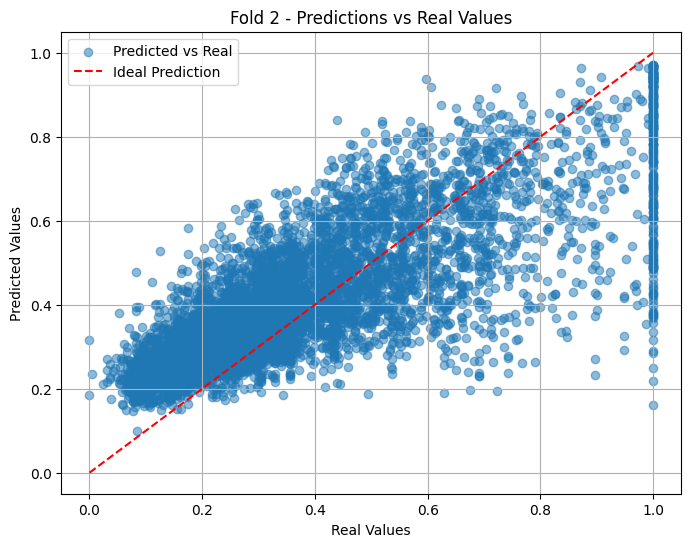

Epoch 1/50, Training Loss: 0.05963123338864938, Validation Loss: 0.05864226361376478
Epoch 2/50, Training Loss: 0.05588887627870713, Validation Loss: 0.05460226898941768
Epoch 3/50, Training Loss: 0.0575248544712885, Validation Loss: 0.05653428575548891
Epoch 4/50, Training Loss: 0.04718641185839742, Validation Loss: 0.04563766743733233
Epoch 5/50, Training Loss: 0.060662946027782355, Validation Loss: 0.06001277059669343
Epoch 6/50, Training Loss: 0.05129415800553743, Validation Loss: 0.05045685682406672
Epoch 7/50, Training Loss: 0.03687529111348695, Validation Loss: 0.03489554108108245
Epoch 8/50, Training Loss: 0.03881208530653902, Validation Loss: 0.036467459847323115
Epoch 9/50, Training Loss: 0.03401915028192759, Validation Loss: 0.03249731267196103
Epoch 10/50, Training Loss: 0.0671423029095537, Validation Loss: 0.0669111401836155
Epoch 11/50, Training Loss: 0.0301543234519592, Validation Loss: 0.02831946311532286
Epoch 12/50, Training Loss: 0.08092830946877258, Validation Loss:

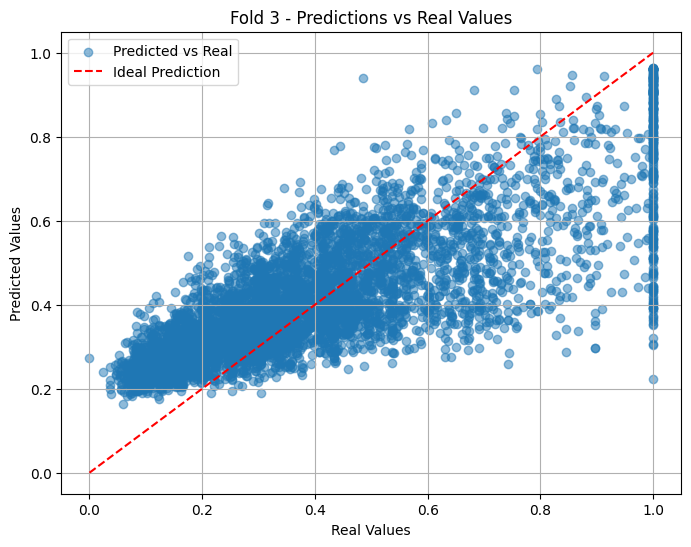

Epoch 1/50, Training Loss: 0.05705114978714319, Validation Loss: 0.056852152812158226
Epoch 2/50, Training Loss: 0.055707027341741634, Validation Loss: 0.0555074112100373
Epoch 3/50, Training Loss: 0.057844057129626876, Validation Loss: 0.05774531856414769
Epoch 4/50, Training Loss: 0.054625069169173104, Validation Loss: 0.054510524091701325
Epoch 5/50, Training Loss: 0.042867336451480685, Validation Loss: 0.04273212368908941
Epoch 6/50, Training Loss: 0.03683397174565249, Validation Loss: 0.036702461979619294
Epoch 7/50, Training Loss: 0.03920372522765098, Validation Loss: 0.039047189957425656
Epoch 8/50, Training Loss: 0.03492780640218773, Validation Loss: 0.034721234877502616
Epoch 9/50, Training Loss: 0.035327185673298296, Validation Loss: 0.03526882768516416
Epoch 10/50, Training Loss: 0.030000416079644845, Validation Loss: 0.02981925776921276
Epoch 11/50, Training Loss: 0.030811825401023805, Validation Loss: 0.03062437764926212
Epoch 12/50, Training Loss: 0.03178582893174649, Val

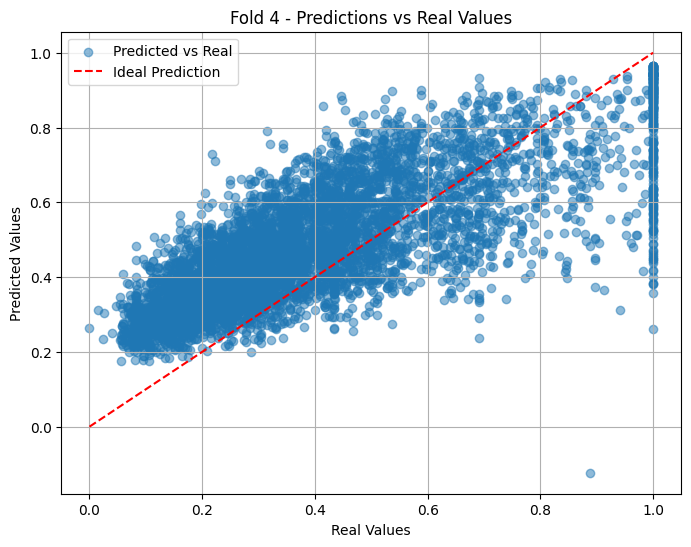

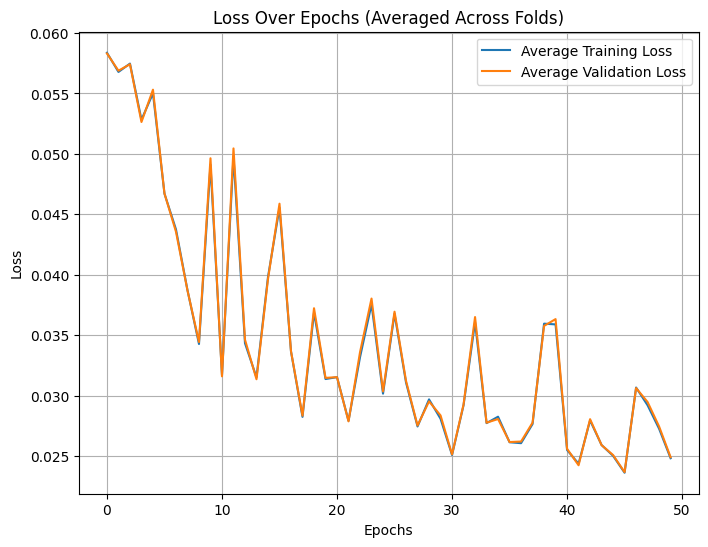

Evaluating Set 4 - Layers: [8, 16, 8, 1], Learning Rate: 0.01, Momentum: 0.9, Activation: relu
Epoch 1/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 2/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 3/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 4/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 5/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 6/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 7/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 8/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 9/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 10/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 11/50, Training Loss: 0.2137425760605977, Validation Loss:

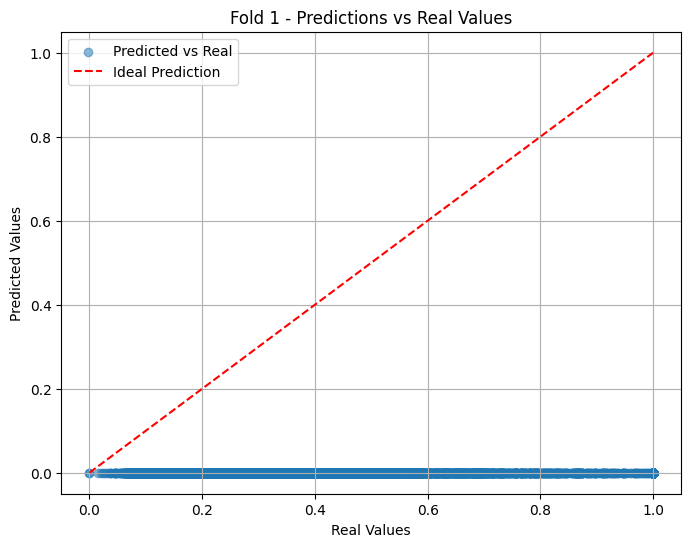

Epoch 1/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 2/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 3/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 4/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 5/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 6/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 7/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 8/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 9/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 10/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 11/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 12/50, Training Loss: 0.2164758905139149, Validation Loss: 0.2123134

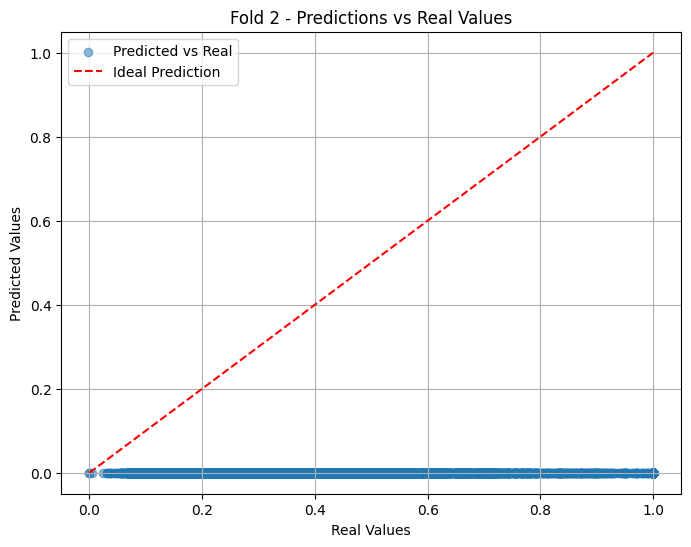

Epoch 1/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 2/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 3/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 4/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 5/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 6/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 7/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 8/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 9/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 10/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 11/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 12/50, Training Loss: 0.21630391127202583, Validation Los

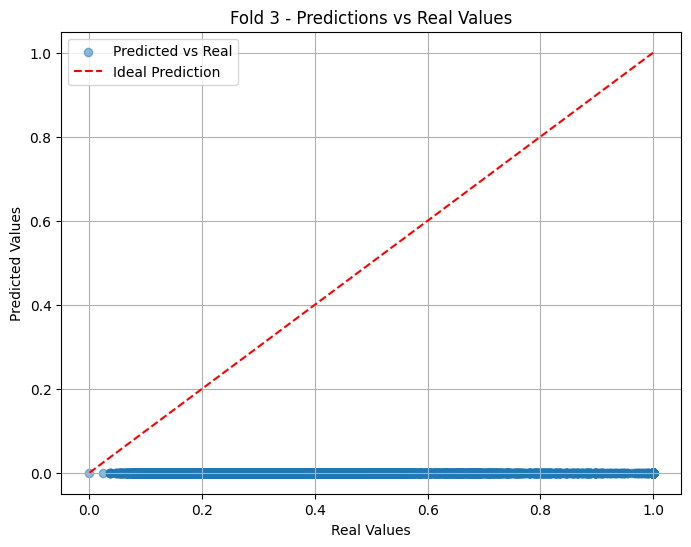

Epoch 1/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 2/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 3/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 4/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 5/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 6/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 7/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 8/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 9/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 10/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 11/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 12/50, Training Loss: 0.2152083192625305, Validation Loss: 0.2161163

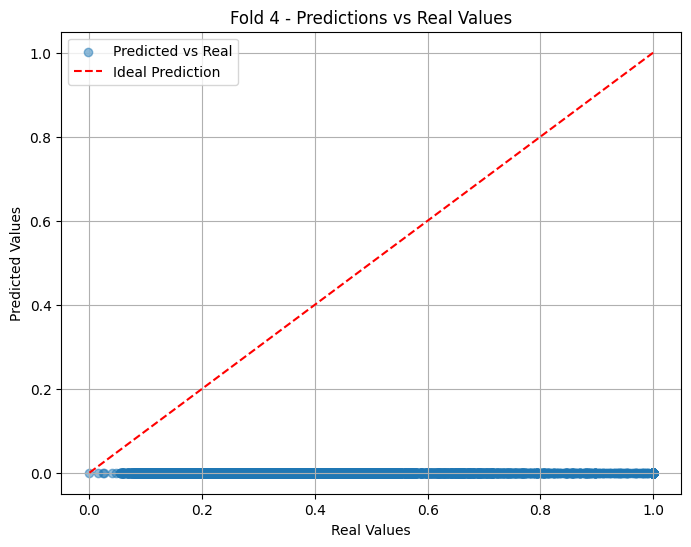

Evaluating Set 5 - Layers: [8, 8, 8, 1], Learning Rate: 1e-05, Momentum: 0.6, Activation: sigmoid
Epoch 1/50, Training Loss: 0.05665985910336867, Validation Loss: 0.059241816834329955
Epoch 2/50, Training Loss: 0.05665425434146824, Validation Loss: 0.05924198515145788
Epoch 3/50, Training Loss: 0.05665060707120706, Validation Loss: 0.059242483595542426
Epoch 4/50, Training Loss: 0.05664832945732964, Validation Loss: 0.059242996626249704
Epoch 5/50, Training Loss: 0.056647565026529935, Validation Loss: 0.05924320940713371
Epoch 6/50, Training Loss: 0.056643810599889356, Validation Loss: 0.059244635022836216
Epoch 7/50, Training Loss: 0.05664245315106638, Validation Loss: 0.05924533885185823
Epoch 8/50, Training Loss: 0.056639744428766875, Validation Loss: 0.059247162073438796
Epoch 9/50, Training Loss: 0.05663708967020251, Validation Loss: 0.05924973324783327
Epoch 10/50, Training Loss: 0.05663744462657125, Validation Loss: 0.05924932544995808
Epoch 11/50, Training Loss: 0.0566353343133

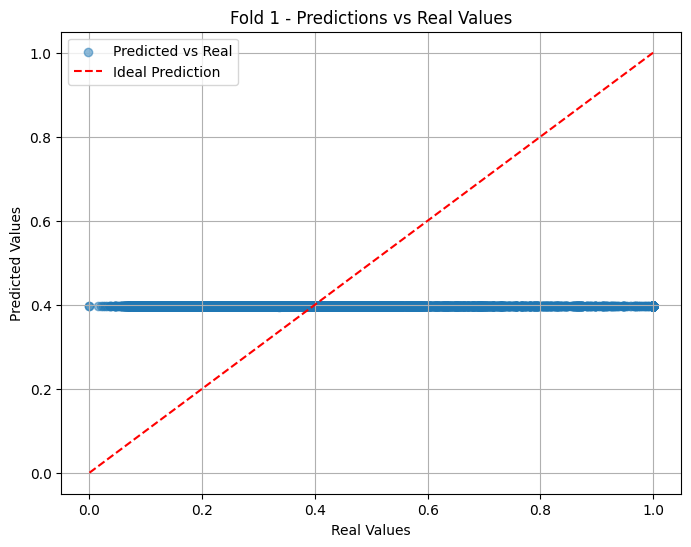

Epoch 1/50, Training Loss: 0.20009132442203684, Validation Loss: 0.19609189232209534
Epoch 2/50, Training Loss: 0.19989993253995836, Validation Loss: 0.19590245892581734
Epoch 3/50, Training Loss: 0.19970381610133292, Validation Loss: 0.1957083506873289
Epoch 4/50, Training Loss: 0.1995045122098689, Validation Loss: 0.19551108905705794
Epoch 5/50, Training Loss: 0.19930197964975707, Validation Loss: 0.1953106333137546
Epoch 6/50, Training Loss: 0.19909504217638005, Validation Loss: 0.19510581936156796
Epoch 7/50, Training Loss: 0.19888296000794153, Validation Loss: 0.1948959151211256
Epoch 8/50, Training Loss: 0.19866597650171647, Validation Loss: 0.1946811615702734
Epoch 9/50, Training Loss: 0.19844407666346392, Validation Loss: 0.194461543989155
Epoch 10/50, Training Loss: 0.19821703968709614, Validation Loss: 0.1942368439690298
Epoch 11/50, Training Loss: 0.19798587644765334, Validation Loss: 0.19400806209965288
Epoch 12/50, Training Loss: 0.19774784270507817, Validation Loss: 0.193

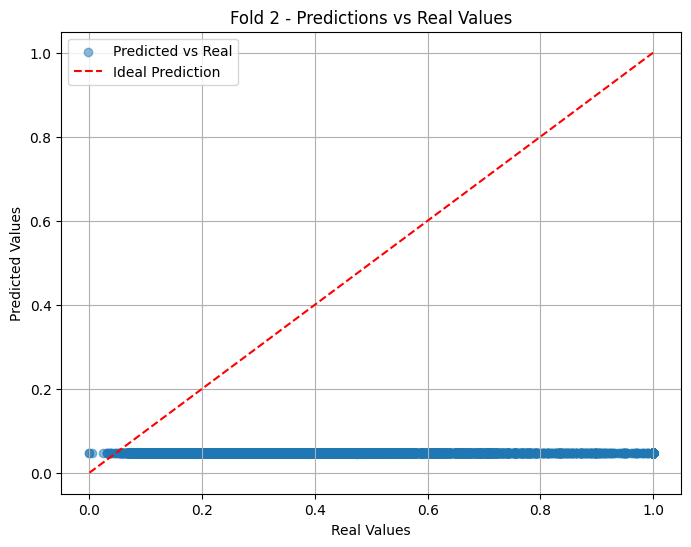

Epoch 1/50, Training Loss: 0.08214981257540335, Validation Loss: 0.08001767234003597
Epoch 2/50, Training Loss: 0.08051710142414781, Validation Loss: 0.07841438746342434
Epoch 3/50, Training Loss: 0.07897620020592004, Validation Loss: 0.07690223539606805
Epoch 4/50, Training Loss: 0.07748172303971768, Validation Loss: 0.07543664882419983
Epoch 5/50, Training Loss: 0.07603975712687759, Validation Loss: 0.07402360676301349
Epoch 6/50, Training Loss: 0.07469599802997816, Validation Loss: 0.07270783793584103
Epoch 7/50, Training Loss: 0.07342215617434733, Validation Loss: 0.07146156469482082
Epoch 8/50, Training Loss: 0.07218755544581354, Validation Loss: 0.07025476367493774
Epoch 9/50, Training Loss: 0.07102763634281459, Validation Loss: 0.06912205580662516
Epoch 10/50, Training Loss: 0.06994042613553814, Validation Loss: 0.06806143979359441
Epoch 11/50, Training Loss: 0.06889163392289206, Validation Loss: 0.06703943652525028
Epoch 12/50, Training Loss: 0.06795912261484986, Validation Los

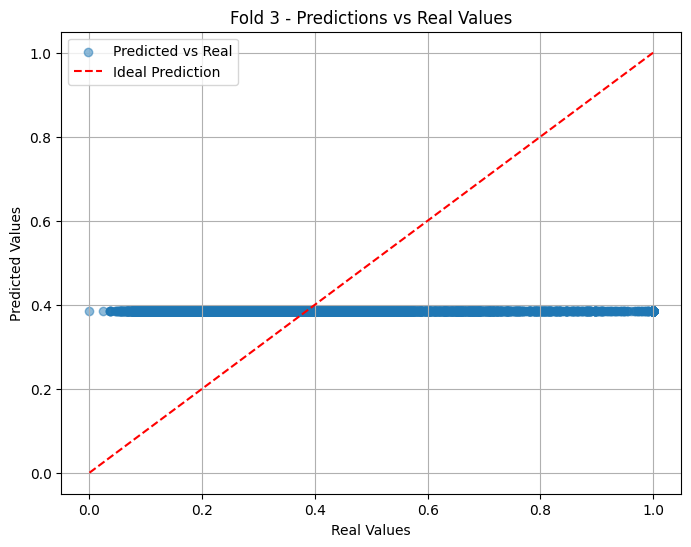

Epoch 1/50, Training Loss: 0.1259020686893719, Validation Loss: 0.1264127964873784
Epoch 2/50, Training Loss: 0.12297979979714538, Validation Loss: 0.12347395908891196
Epoch 3/50, Training Loss: 0.12001886723701506, Validation Loss: 0.12049585713965805
Epoch 4/50, Training Loss: 0.11698668823711939, Validation Loss: 0.1174456688307461
Epoch 5/50, Training Loss: 0.11387628434780345, Validation Loss: 0.11431630763526054
Epoch 6/50, Training Loss: 0.1107608412832992, Validation Loss: 0.11118134510598449
Epoch 7/50, Training Loss: 0.10757962151523852, Validation Loss: 0.10797959587004197
Epoch 8/50, Training Loss: 0.10442926897354628, Validation Loss: 0.10480826084436093
Epoch 9/50, Training Loss: 0.10127352749324503, Validation Loss: 0.10163078362355807
Epoch 10/50, Training Loss: 0.09818956196776867, Validation Loss: 0.09852480762742827
Epoch 11/50, Training Loss: 0.09515351385520729, Validation Loss: 0.09546626250062873
Epoch 12/50, Training Loss: 0.09211803313753941, Validation Loss: 0

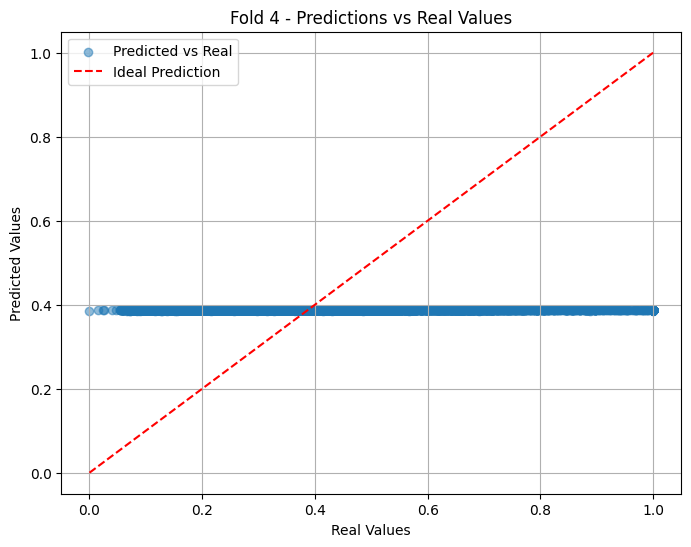

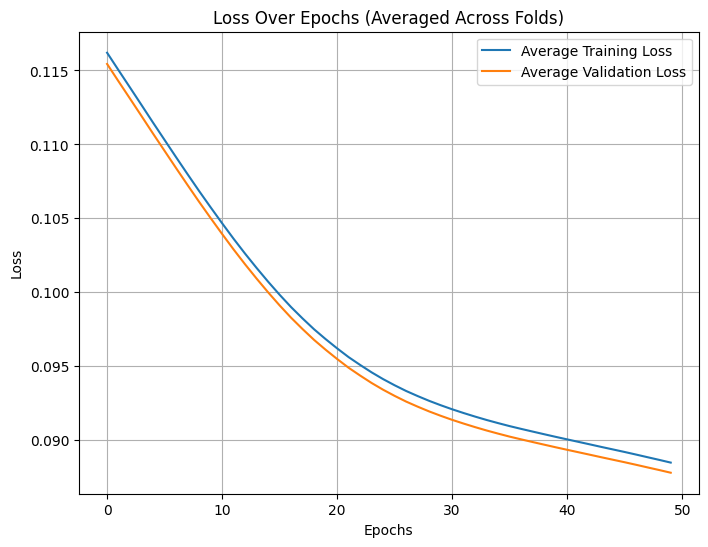

Evaluating Set 6 - Layers: [8, 20, 15, 1], Learning Rate: 0.001, Momentum: 0.3, Activation: relu
Epoch 1/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 2/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 3/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 4/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 5/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 6/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 7/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 8/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 9/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 10/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 11/50, Training Loss: 0.2137425760605977, Validation Los

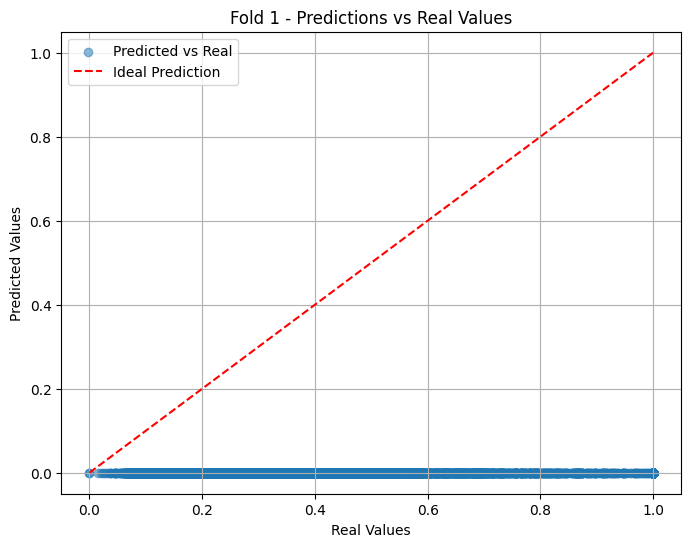

Epoch 1/50, Training Loss: 0.05676962858524999, Validation Loss: 0.05578824064125
Epoch 2/50, Training Loss: 0.05648723779124855, Validation Loss: 0.05560396698692859
Epoch 3/50, Training Loss: 0.05658482325811006, Validation Loss: 0.05577414759820484
Epoch 4/50, Training Loss: 0.056402256489101646, Validation Loss: 0.055341418166742866
Epoch 5/50, Training Loss: 0.056230244584065746, Validation Loss: 0.0551848985277366
Epoch 6/50, Training Loss: 0.055801618806322444, Validation Loss: 0.05491008931706545
Epoch 7/50, Training Loss: 0.055619364714715284, Validation Loss: 0.0547043654910951
Epoch 8/50, Training Loss: 0.05577207118893186, Validation Loss: 0.054751813358121924
Epoch 9/50, Training Loss: 0.055862773405127346, Validation Loss: 0.055167294700019055
Epoch 10/50, Training Loss: 0.05506531091354596, Validation Loss: 0.05415425646092626
Epoch 11/50, Training Loss: 0.05478558243391649, Validation Loss: 0.05394975360200578
Epoch 12/50, Training Loss: 0.054669171855732175, Validation

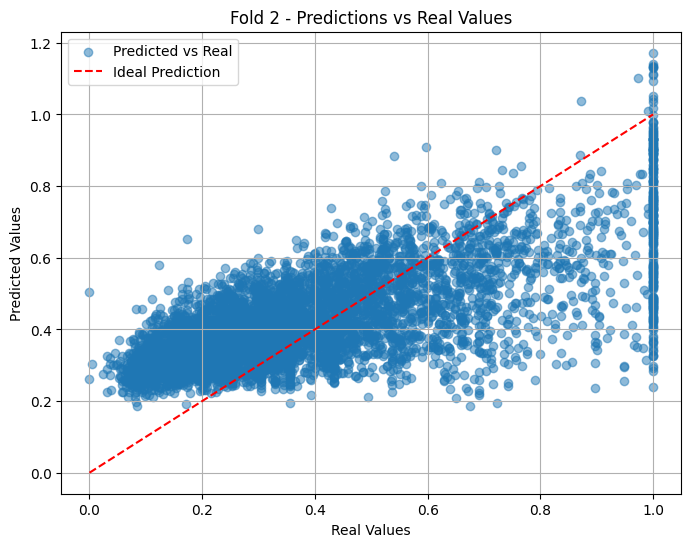

Epoch 1/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 2/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 3/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 4/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 5/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 6/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 7/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 8/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 9/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 10/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 11/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 12/50, Training Loss: 0.21630391127202583, Validation Los

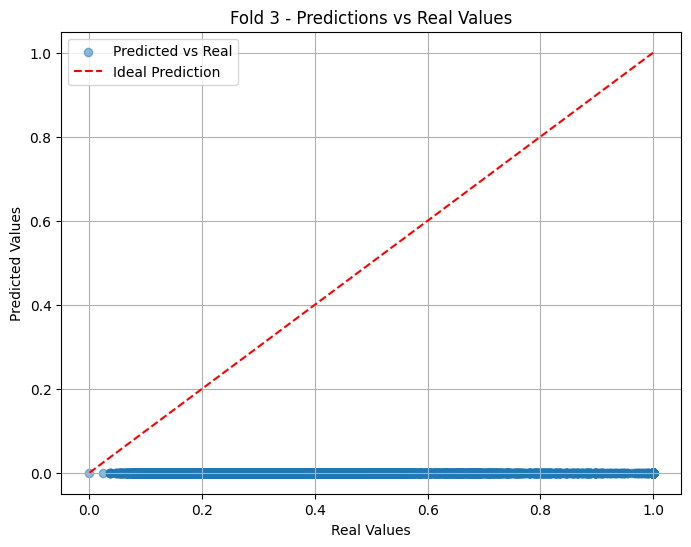

Epoch 1/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 2/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 3/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 4/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 5/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 6/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 7/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 8/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 9/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 10/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 11/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 12/50, Training Loss: 0.2152083192625305, Validation Loss: 0.2161163

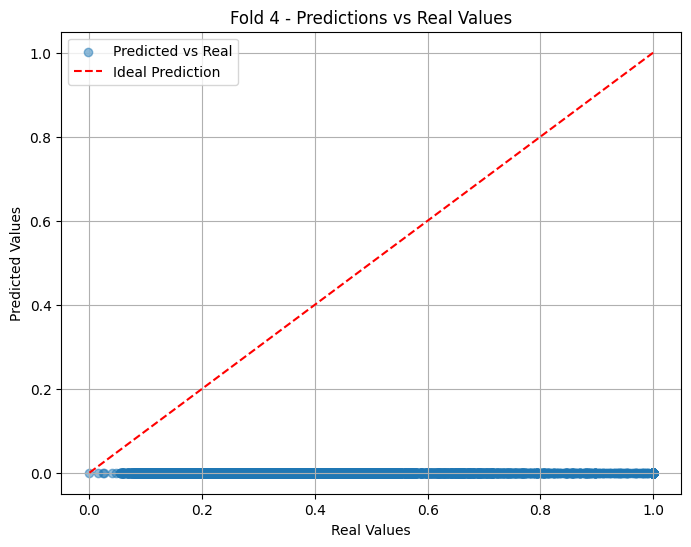

Evaluating Set 7 - Layers: [8, 12, 8, 1], Learning Rate: 0.01, Momentum: 0.8, Activation: tanh
Epoch 1/50, Training Loss: 0.05664346288429677, Validation Loss: 0.05904505380508033
Epoch 2/50, Training Loss: 0.056020966203207595, Validation Loss: 0.05887252008602438
Epoch 3/50, Training Loss: 0.05421892030667583, Validation Loss: 0.05671110601115282
Epoch 4/50, Training Loss: 0.05102982535122209, Validation Loss: 0.05358683629914678
Epoch 5/50, Training Loss: 0.048311510523116157, Validation Loss: 0.051170871994083815
Epoch 6/50, Training Loss: 0.04893545020259422, Validation Loss: 0.05034116410882251
Epoch 7/50, Training Loss: 0.04197072708573352, Validation Loss: 0.04452026606671285
Epoch 8/50, Training Loss: 0.03953889763074226, Validation Loss: 0.04090857743772744
Epoch 9/50, Training Loss: 0.03158757484352882, Validation Loss: 0.033383942612271754
Epoch 10/50, Training Loss: 0.03775536508253631, Validation Loss: 0.039061455027000994
Epoch 11/50, Training Loss: 0.04602169178924211, 

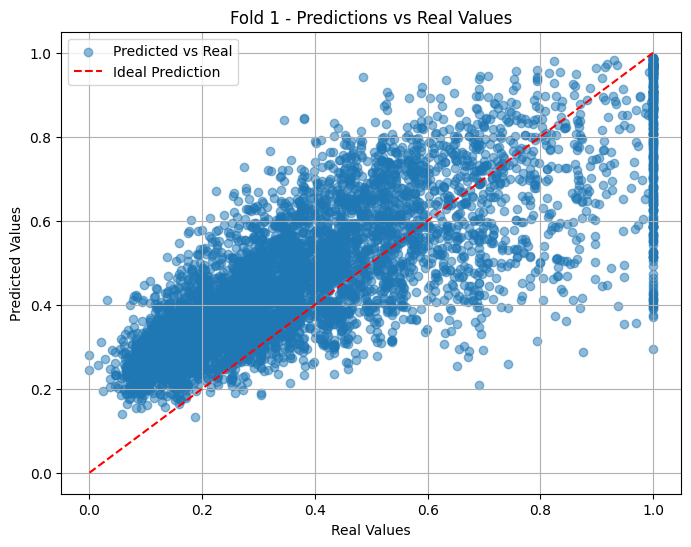

Epoch 1/50, Training Loss: 0.06685855915247434, Validation Loss: 0.06523668278709242
Epoch 2/50, Training Loss: 0.049660864453623575, Validation Loss: 0.049074148292159295
Epoch 3/50, Training Loss: 0.04761264277105797, Validation Loss: 0.04720713157518379
Epoch 4/50, Training Loss: 0.03825433906200586, Validation Loss: 0.038203426103858684
Epoch 5/50, Training Loss: 0.06202647709471061, Validation Loss: 0.062064448432476535
Epoch 6/50, Training Loss: 0.03375821263880468, Validation Loss: 0.0338536730397037
Epoch 7/50, Training Loss: 0.03454344841638771, Validation Loss: 0.03460101241945232
Epoch 8/50, Training Loss: 0.03463458182532265, Validation Loss: 0.034638893773013525
Epoch 9/50, Training Loss: 0.030419608431847968, Validation Loss: 0.030561698635676426
Epoch 10/50, Training Loss: 0.03983818944462965, Validation Loss: 0.03975407973251276
Epoch 11/50, Training Loss: 0.03403970078401397, Validation Loss: 0.034519956694706935
Epoch 12/50, Training Loss: 0.03738100087225213, Validat

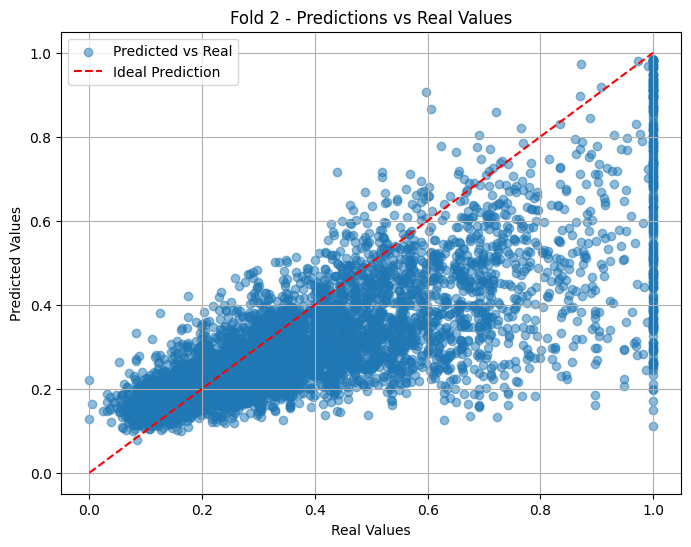

Epoch 1/50, Training Loss: 0.057017787545970866, Validation Loss: 0.055744338686540544
Epoch 2/50, Training Loss: 0.0571983450506398, Validation Loss: 0.056056943504897705
Epoch 3/50, Training Loss: 0.05512490887605183, Validation Loss: 0.05380490319250512
Epoch 4/50, Training Loss: 0.05340553564029861, Validation Loss: 0.05176798348782465
Epoch 5/50, Training Loss: 0.04701981412860421, Validation Loss: 0.045665487931550564
Epoch 6/50, Training Loss: 0.056063512277104606, Validation Loss: 0.05528149251925851
Epoch 7/50, Training Loss: 0.04317836838748437, Validation Loss: 0.040975437981992206
Epoch 8/50, Training Loss: 0.03515052667794258, Validation Loss: 0.03357005372970927
Epoch 9/50, Training Loss: 0.033644369014935324, Validation Loss: 0.03193802715400785
Epoch 10/50, Training Loss: 0.03172727083985848, Validation Loss: 0.030146186124029316
Epoch 11/50, Training Loss: 0.03178027069193373, Validation Loss: 0.03007645521006863
Epoch 12/50, Training Loss: 0.03271246437711333, Validat

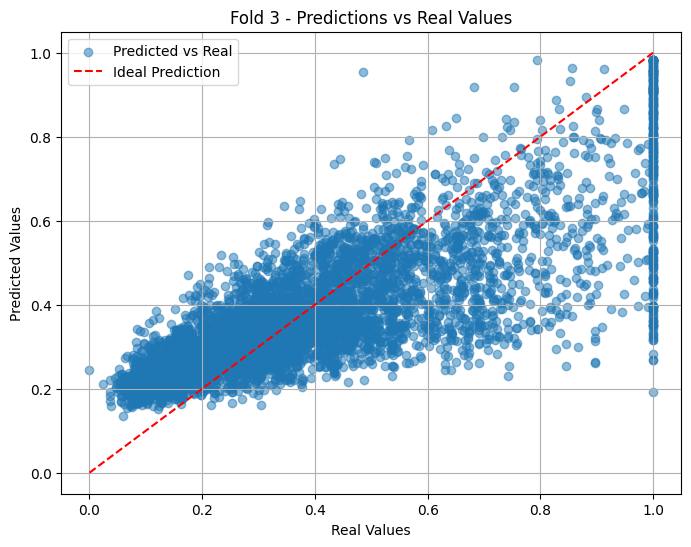

Epoch 1/50, Training Loss: 0.057149127604896696, Validation Loss: 0.056968552305918636
Epoch 2/50, Training Loss: 0.05575779949038034, Validation Loss: 0.05538415640323723
Epoch 3/50, Training Loss: 0.048706265641511, Validation Loss: 0.048475016003373075
Epoch 4/50, Training Loss: 0.041963473055426165, Validation Loss: 0.041757456579359746
Epoch 5/50, Training Loss: 0.05441804703268316, Validation Loss: 0.054358285507533896
Epoch 6/50, Training Loss: 0.03489116762671124, Validation Loss: 0.03483855934199663
Epoch 7/50, Training Loss: 0.03489039344170474, Validation Loss: 0.034886080400499925
Epoch 8/50, Training Loss: 0.04130066126704345, Validation Loss: 0.04135832889445381
Epoch 9/50, Training Loss: 0.031864227425588684, Validation Loss: 0.031914422571221436
Epoch 10/50, Training Loss: 0.03531392845958207, Validation Loss: 0.03530045326985721
Epoch 11/50, Training Loss: 0.03553939903177076, Validation Loss: 0.035465552721586795
Epoch 12/50, Training Loss: 0.039388044393243074, Valid

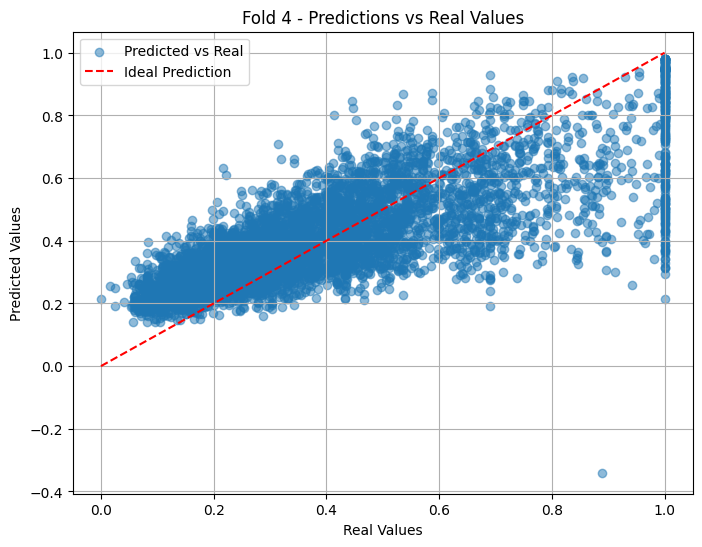

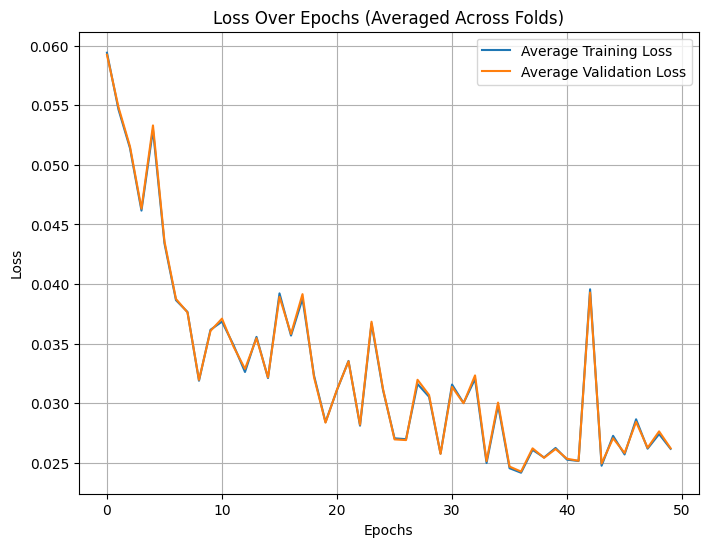

Evaluating Set 8 - Layers: [8, 15, 1], Learning Rate: 0.0001, Momentum: 0.4, Activation: linear
Epoch 1/50, Training Loss: 0.05644659207400329, Validation Loss: 0.059096535542551114
Epoch 2/50, Training Loss: 0.05642563273371551, Validation Loss: 0.05908743975924633
Epoch 3/50, Training Loss: 0.05640897767345616, Validation Loss: 0.05904538248787515
Epoch 4/50, Training Loss: 0.056395232641867084, Validation Loss: 0.059085485019036516
Epoch 5/50, Training Loss: 0.05637436298052062, Validation Loss: 0.05899596734968077
Epoch 6/50, Training Loss: 0.05637394600166218, Validation Loss: 0.0590875713056214
Epoch 7/50, Training Loss: 0.05632139676091494, Validation Loss: 0.05897503990752291
Epoch 8/50, Training Loss: 0.05633110847193368, Validation Loss: 0.0589295104505824
Epoch 9/50, Training Loss: 0.05628936141540704, Validation Loss: 0.05891226687639643
Epoch 10/50, Training Loss: 0.056268444470430425, Validation Loss: 0.058953988111827164
Epoch 11/50, Training Loss: 0.05625515058691225, V

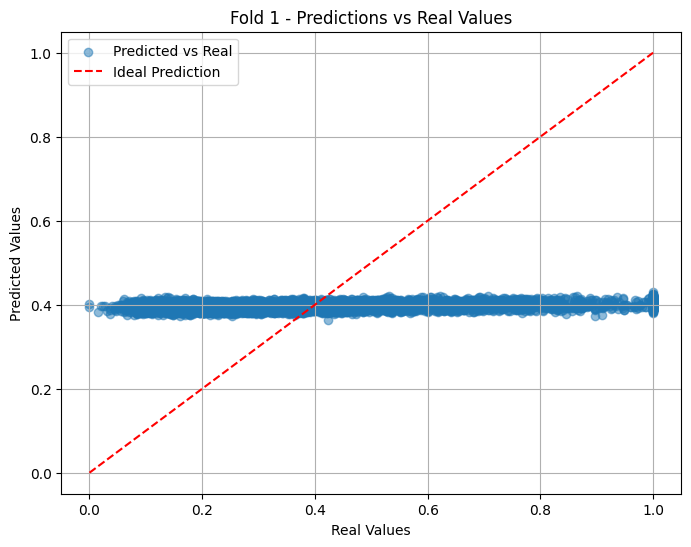

Epoch 1/50, Training Loss: 0.057512702133280025, Validation Loss: 0.05645366392577832
Epoch 2/50, Training Loss: 0.05748830231488581, Validation Loss: 0.05640221967106922
Epoch 3/50, Training Loss: 0.057475892819229074, Validation Loss: 0.05638726469275519
Epoch 4/50, Training Loss: 0.057493631936227, Validation Loss: 0.05645379683177536
Epoch 5/50, Training Loss: 0.05746937276537723, Validation Loss: 0.0564216788485607
Epoch 6/50, Training Loss: 0.05743708992900887, Validation Loss: 0.056357910417767935
Epoch 7/50, Training Loss: 0.05742461209658228, Validation Loss: 0.05634968593970178
Epoch 8/50, Training Loss: 0.057429719791979514, Validation Loss: 0.056382814969591084
Epoch 9/50, Training Loss: 0.05739874629653696, Validation Loss: 0.0563163915127809
Epoch 10/50, Training Loss: 0.05740764936320603, Validation Loss: 0.05636523487836674
Epoch 11/50, Training Loss: 0.057375127289505015, Validation Loss: 0.05628598424152747
Epoch 12/50, Training Loss: 0.057374586992917004, Validation 

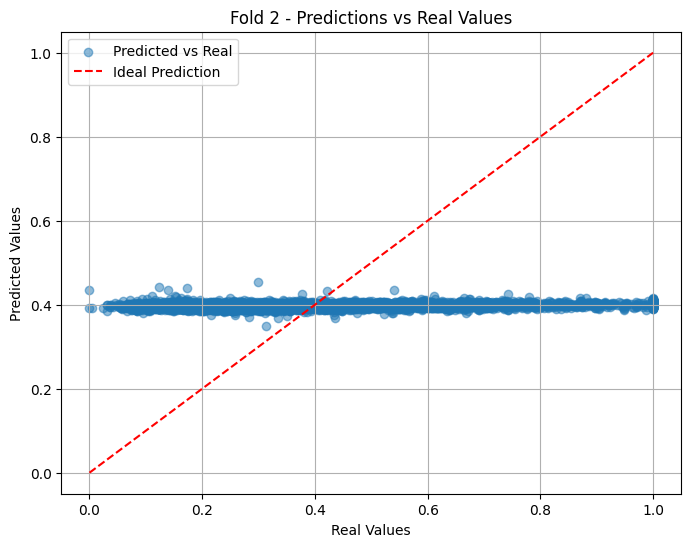

Epoch 1/50, Training Loss: 0.05669986595303441, Validation Loss: 0.05546354213312545
Epoch 2/50, Training Loss: 0.056662758712460286, Validation Loss: 0.05540935400931412
Epoch 3/50, Training Loss: 0.05664695633378311, Validation Loss: 0.05537068801818894
Epoch 4/50, Training Loss: 0.05664626582286197, Validation Loss: 0.055355176126165806
Epoch 5/50, Training Loss: 0.05661780303034362, Validation Loss: 0.055332074302515744
Epoch 6/50, Training Loss: 0.05660225226708928, Validation Loss: 0.05536109525953648
Epoch 7/50, Training Loss: 0.056573305673487465, Validation Loss: 0.055292617153536394
Epoch 8/50, Training Loss: 0.05655193849160094, Validation Loss: 0.05529885306672009
Epoch 9/50, Training Loss: 0.05653510696227716, Validation Loss: 0.055283164795031633
Epoch 10/50, Training Loss: 0.056571614805992, Validation Loss: 0.05526048996068766
Epoch 11/50, Training Loss: 0.0565838818804205, Validation Loss: 0.055262281231709585
Epoch 12/50, Training Loss: 0.056485267061380705, Validatio

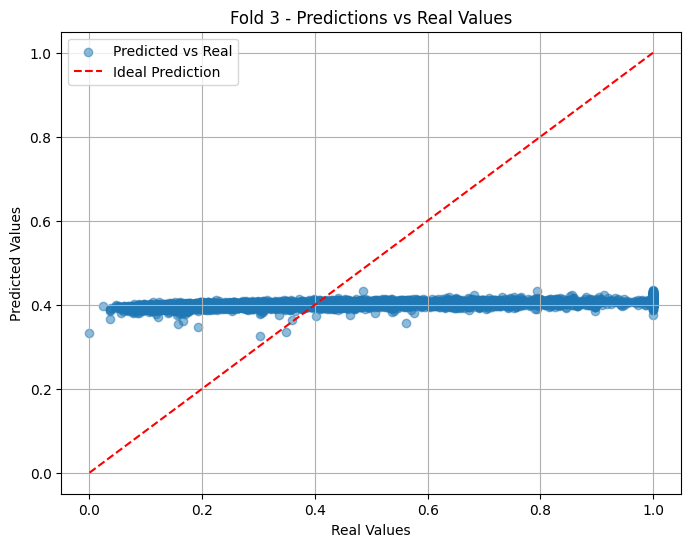

Epoch 1/50, Training Loss: 0.059079672629694345, Validation Loss: 0.05893430860865614
Epoch 2/50, Training Loss: 0.059071469916355125, Validation Loss: 0.05890643792531626
Epoch 3/50, Training Loss: 0.05903678813480058, Validation Loss: 0.05887294431480698
Epoch 4/50, Training Loss: 0.05900766540950021, Validation Loss: 0.058871331376113716
Epoch 5/50, Training Loss: 0.0589964629470618, Validation Loss: 0.05882603835589957
Epoch 6/50, Training Loss: 0.05898138622789821, Validation Loss: 0.058807455451577395
Epoch 7/50, Training Loss: 0.05899765201452221, Validation Loss: 0.05887772642558971
Epoch 8/50, Training Loss: 0.05895991456466465, Validation Loss: 0.058778461159792524
Epoch 9/50, Training Loss: 0.05883736017534359, Validation Loss: 0.05868958546069209
Epoch 10/50, Training Loss: 0.05910438581483108, Validation Loss: 0.058898911767557245
Epoch 11/50, Training Loss: 0.05878736723841883, Validation Loss: 0.05864558368136903
Epoch 12/50, Training Loss: 0.05875266558335097, Validatio

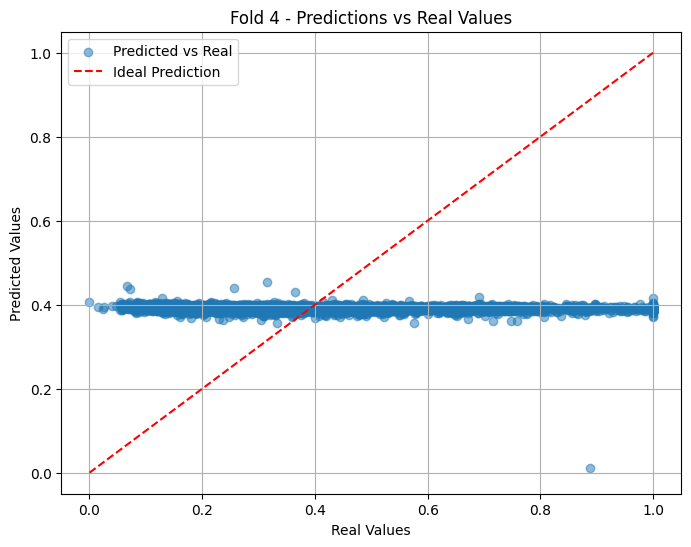

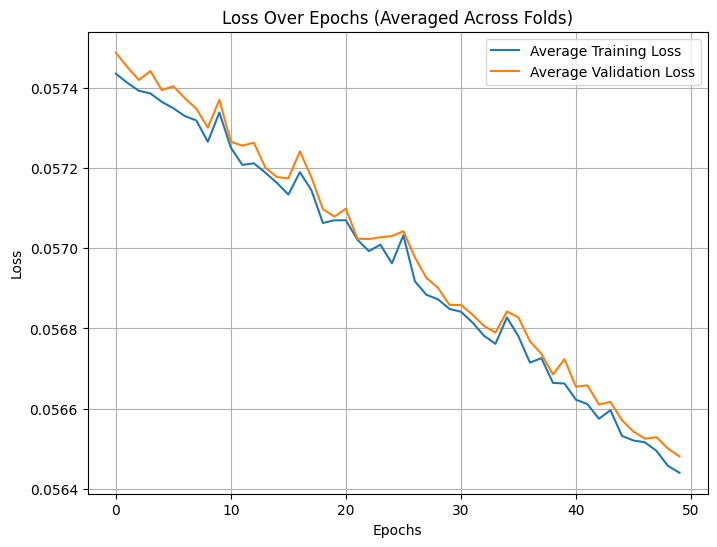

Evaluating Set 9 - Layers: [8, 18, 14, 1], Learning Rate: 0.0001, Momentum: 0.5, Activation: relu
Epoch 1/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 2/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 3/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 4/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 5/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 6/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 7/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 8/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 9/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 10/50, Training Loss: 0.2137425760605977, Validation Loss: 0.22051388316403753
Epoch 11/50, Training Loss: 0.2137425760605977, Validation Lo

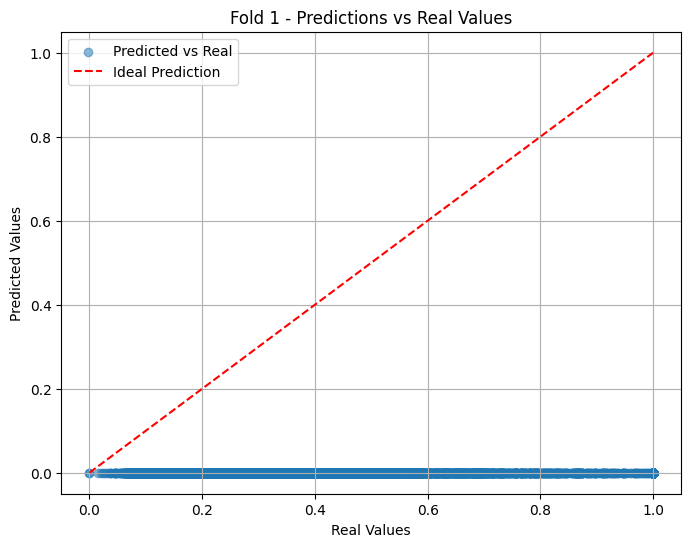

Epoch 1/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 2/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 3/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 4/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 5/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 6/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 7/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 8/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 9/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 10/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 11/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 12/50, Training Loss: 0.2164758905139149, Validation Loss: 0.2123134

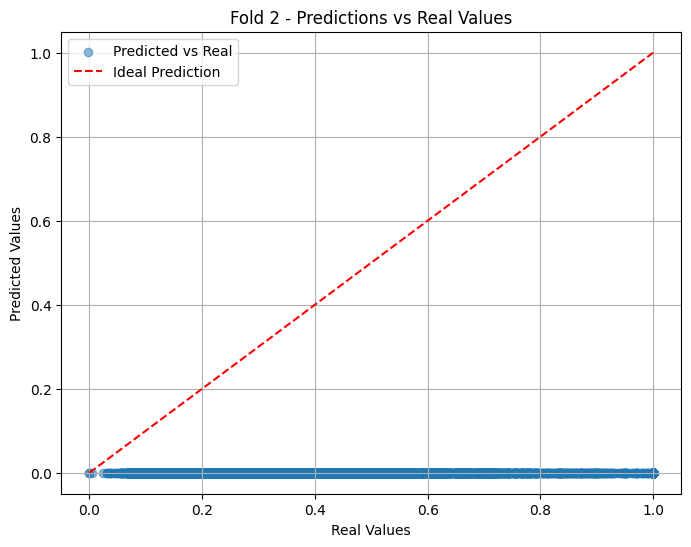

Epoch 1/50, Training Loss: 0.05747634155747173, Validation Loss: 0.05613113078435172
Epoch 2/50, Training Loss: 0.05734219205862162, Validation Loss: 0.0560981886292741
Epoch 3/50, Training Loss: 0.05730536827981887, Validation Loss: 0.05601726297433586
Epoch 4/50, Training Loss: 0.057360915822385325, Validation Loss: 0.05603741194977907
Epoch 5/50, Training Loss: 0.05728710966325212, Validation Loss: 0.055995897701180845
Epoch 6/50, Training Loss: 0.05726980679450612, Validation Loss: 0.05599262718321719
Epoch 7/50, Training Loss: 0.0572953926029949, Validation Loss: 0.05605177250832521
Epoch 8/50, Training Loss: 0.05725008345207088, Validation Loss: 0.05597779559077451
Epoch 9/50, Training Loss: 0.057242663185103904, Validation Loss: 0.05597566326084221
Epoch 10/50, Training Loss: 0.057230985691944, Validation Loss: 0.05596181258536043
Epoch 11/50, Training Loss: 0.05722718817416806, Validation Loss: 0.055930912867147325
Epoch 12/50, Training Loss: 0.057207782108692824, Validation Lo

Epoch 1/50, Training Loss: 0.05685744484748806, Validation Loss: 0.05653501425743723
Epoch 2/50, Training Loss: 0.05691884107897541, Validation Loss: 0.05658151231546327
Epoch 3/50, Training Loss: 0.056822071268785246, Validation Loss: 0.05650186736130153
Epoch 4/50, Training Loss: 0.056820892629686454, Validation Loss: 0.05649644395004854
Epoch 5/50, Training Loss: 0.056811094511381756, Validation Loss: 0.056485446523576795
Epoch 6/50, Training Loss: 0.05680979922828634, Validation Loss: 0.05651610369416012
Epoch 7/50, Training Loss: 0.056762647272007076, Validation Loss: 0.056443472125861774
Epoch 8/50, Training Loss: 0.05676919744104445, Validation Loss: 0.05647256794762094
Epoch 9/50, Training Loss: 0.05680819389946324, Validation Loss: 0.05652135909357801
Epoch 10/50, Training Loss: 0.05676124904086829, Validation Loss: 0.05643046614905721
Epoch 11/50, Training Loss: 0.05672363894761028, Validation Loss: 0.056397811669298616
Epoch 12/50, Training Loss: 0.05670343032069803, Validat

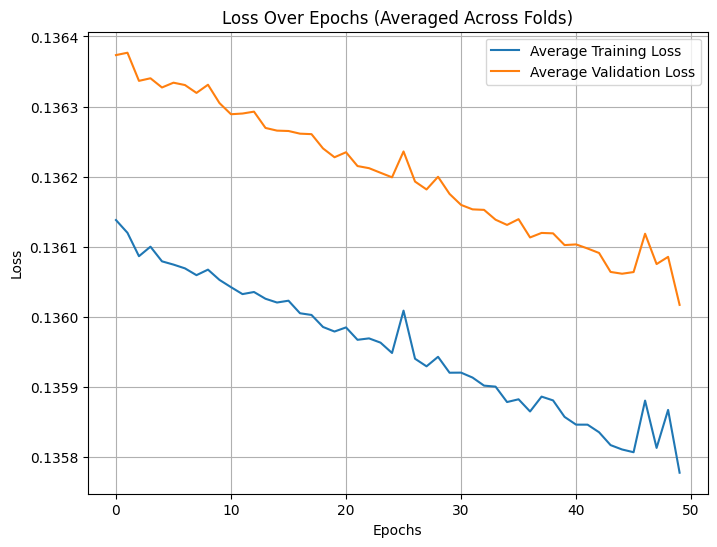

Evaluating Set 10 - Layers: [8, 14, 7, 1], Learning Rate: 1e-05, Momentum: 0.7, Activation: sigmoid
Epoch 1/50, Training Loss: 0.08801210306584066, Validation Loss: 0.08880130731433122
Epoch 2/50, Training Loss: 0.08184282020626091, Validation Loss: 0.08282343531782117
Epoch 3/50, Training Loss: 0.07678899009589837, Validation Loss: 0.07794473033866303
Epoch 4/50, Training Loss: 0.07278602093599565, Validation Loss: 0.07409678884494109
Epoch 5/50, Training Loss: 0.06950622100154254, Validation Loss: 0.0709590460594336
Epoch 6/50, Training Loss: 0.06689107539132143, Validation Loss: 0.06847076333133828
Epoch 7/50, Training Loss: 0.06475961874407676, Validation Loss: 0.06645527208978086
Epoch 8/50, Training Loss: 0.06309510553319199, Validation Loss: 0.06489238710469186
Epoch 9/50, Training Loss: 0.06178488417101892, Validation Loss: 0.06367178928590601
Epoch 10/50, Training Loss: 0.06075305130580007, Validation Loss: 0.06271891232199227
Epoch 11/50, Training Loss: 0.059947599665360556, 

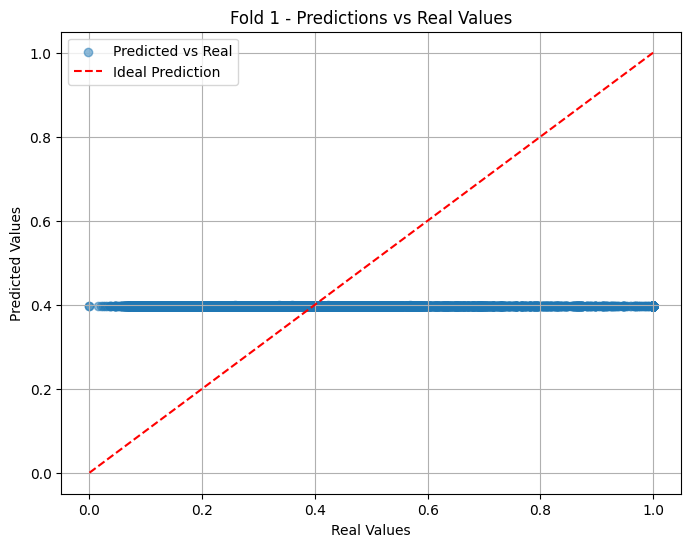

Epoch 1/50, Training Loss: 0.35161566262922833, Validation Loss: 0.3547144391303243
Epoch 2/50, Training Loss: 0.3480469418176668, Validation Loss: 0.35112026401631796
Epoch 3/50, Training Loss: 0.3441542011558999, Validation Loss: 0.3471995791057
Epoch 4/50, Training Loss: 0.3398717872354577, Validation Loss: 0.3428862035804247
Epoch 5/50, Training Loss: 0.3351938570862627, Validation Loss: 0.3381741826768141
Epoch 6/50, Training Loss: 0.3300754529010757, Validation Loss: 0.33301814693127046
Epoch 7/50, Training Loss: 0.32441089673110435, Validation Loss: 0.3273115291566783
Epoch 8/50, Training Loss: 0.3181982110843434, Validation Loss: 0.3210521947147629
Epoch 9/50, Training Loss: 0.3113533152718399, Validation Loss: 0.3141552538567726
Epoch 10/50, Training Loss: 0.303733361037214, Validation Loss: 0.3064765276622831
Epoch 11/50, Training Loss: 0.29532593769311666, Validation Loss: 0.29800319123362534
Epoch 12/50, Training Loss: 0.2859807504357857, Validation Loss: 0.2885833533639629

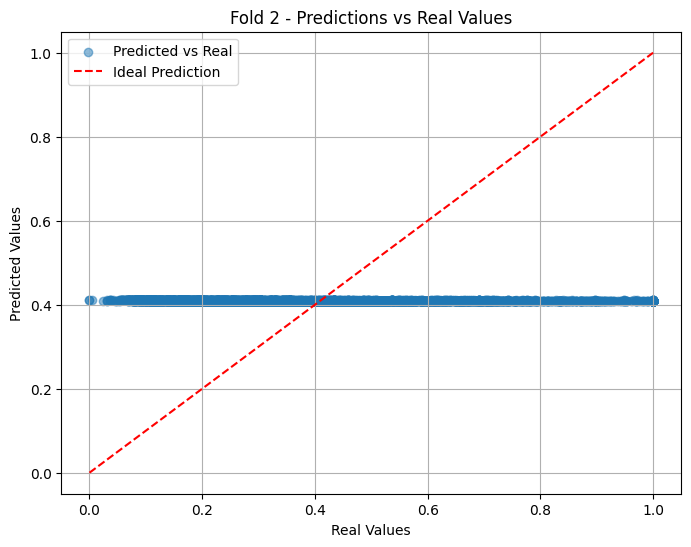

Epoch 1/50, Training Loss: 0.0889366368040607, Validation Loss: 0.08669115788088604
Epoch 2/50, Training Loss: 0.08593110960710851, Validation Loss: 0.08373394314943579
Epoch 3/50, Training Loss: 0.08305456387750343, Validation Loss: 0.08090610118676705
Epoch 4/50, Training Loss: 0.08039118641685619, Validation Loss: 0.07829033787344729
Epoch 5/50, Training Loss: 0.07782770793278916, Validation Loss: 0.0757753946664778
Epoch 6/50, Training Loss: 0.07549879069916665, Validation Loss: 0.07349331604785404
Epoch 7/50, Training Loss: 0.07336242593435917, Validation Loss: 0.07140267957575741
Epoch 8/50, Training Loss: 0.07141964291630841, Validation Loss: 0.06950425673497503
Epoch 9/50, Training Loss: 0.06966722207495324, Validation Loss: 0.06779461068396996
Epoch 10/50, Training Loss: 0.06806156716578131, Validation Loss: 0.06623096922227521
Epoch 11/50, Training Loss: 0.06670435121997613, Validation Loss: 0.06491185769326863
Epoch 12/50, Training Loss: 0.06543630216092264, Validation Loss:

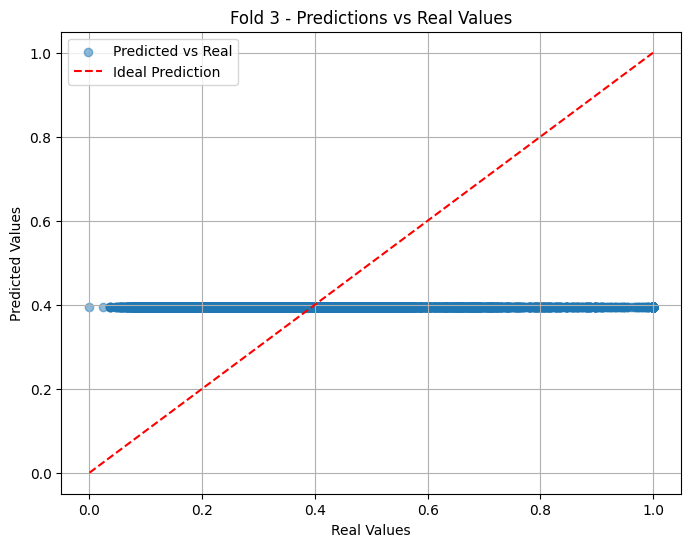

Epoch 1/50, Training Loss: 0.060851938988981794, Validation Loss: 0.060766848197544056
Epoch 2/50, Training Loss: 0.06023721071248175, Validation Loss: 0.06013611379421077
Epoch 3/50, Training Loss: 0.05972980569731901, Validation Loss: 0.059614154684367524
Epoch 4/50, Training Loss: 0.059318823904236186, Validation Loss: 0.059190196819489956
Epoch 5/50, Training Loss: 0.058970584845437865, Validation Loss: 0.05882985140347984
Epoch 6/50, Training Loss: 0.058672439954174094, Validation Loss: 0.05852025454941214
Epoch 7/50, Training Loss: 0.058403607871903504, Validation Loss: 0.058239921135663515
Epoch 8/50, Training Loss: 0.05818373740412164, Validation Loss: 0.05800948849928893
Epoch 9/50, Training Loss: 0.0580453925064648, Validation Loss: 0.057863760047471124
Epoch 10/50, Training Loss: 0.05791770828937192, Validation Loss: 0.057728569959246114
Epoch 11/50, Training Loss: 0.05780920609390119, Validation Loss: 0.057612985632254525
Epoch 12/50, Training Loss: 0.05771996118299139, Val

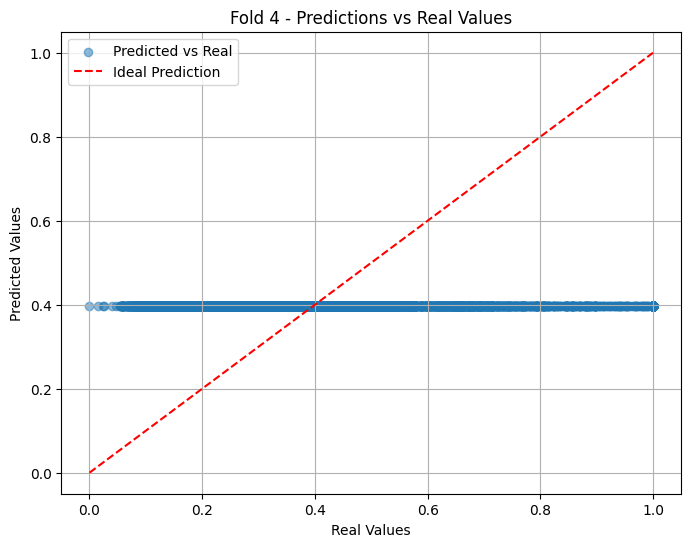

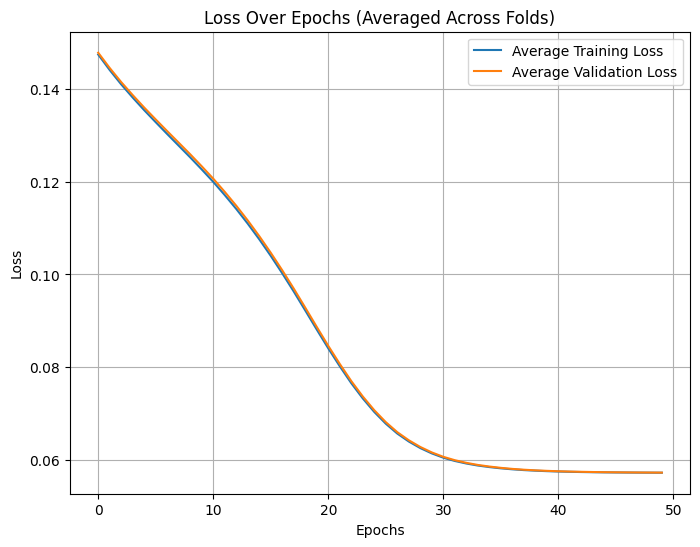

   Set  MSE_Mean   MSE_Std  MAE_Mean   MAE_Std   MAPE_Mean   MAPE_Std
0    3  0.024918  0.002808  0.124602  0.011984   48.180293   6.425941
1    7  0.026213  0.003701  0.120385  0.010679   41.301843   8.586289
2    8  0.056481  0.001436  0.187775  0.002129   74.917156   1.366541
3    1  0.057225  0.001182  0.189540  0.001980   75.830753   1.335254
4   10  0.057345  0.001128  0.190085  0.002482   76.388116   2.483165
5    5  0.087792  0.052230  0.228395  0.069727   75.743992   4.492503
6    9  0.136017  0.080449  0.291982  0.106242   86.675909  13.324805
7    2  0.137191  0.079284  0.291479  0.106746   84.355507  15.978203
8    6  0.170154  0.080297  0.334304  0.111493   89.560060  18.082506
9    4  0.215443  0.003271  0.397696  0.002703  100.000000   0.000000
Best Hyperparameter Set: Set           3.000000
MSE_Mean      0.024918
MSE_Std       0.002808
MAE_Mean      0.124602
MAE_Std       0.011984
MAPE_Mean    48.180293
MAPE_Std      6.425941
Name: 0, dtype: float64


In [ ]:
# Function to calculate MAPE without masking
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Create a mask to exclude zero or near-zero values in y_true
    mask = y_true > 1e-10
    y_true_masked = y_true[mask]
    y_pred_masked = y_pred[mask]
    
    # Calculate MAPE only for valid values
    return np.mean(np.abs((y_true_masked - y_pred_masked) / y_true_masked)) * 100


# Function to normalize metrics (for fair comparison)
def normalize_metric(metric_values):
    return (metric_values - np.min(metric_values)) / (np.max(metric_values) - np.min(metric_values))

# Function to evaluate the neural network with given hyperparameters using cross-validation

def evaluate_model_with_cross_validation(layers, epochs, learning_rate, momentum, activation, k_folds=4):
    """
    Perform k-fold cross-validation and return average validation metrics and their standard deviations.
    """
    fold_size = len(X_train_scaled) // k_folds  # Determine the size of each fold
    metrics_list = []  # To store metrics for each fold
    overall_train_loss, overall_val_loss = [], []  # To store loss curves across folds

    for fold in range(k_folds):
        # Split data into training and validation subsets
        start, end = fold * fold_size, (fold + 1) * fold_size
        X_val_fold, y_val_fold = X_train_scaled[start:end], y_train[start:end]
        X_train_fold = np.concatenate([X_train_scaled[:start], X_train_scaled[end:]])
        y_train_fold = np.concatenate([y_train[:start], y_train[end:]])

        # Initialize the neural network
        nn_model = NeuralNet(
            layers=layers,
            epochs=epochs,
            learning_rate=learning_rate,
            momentum=momentum,
            activation=activation
        )
        
        # Train the model
        train_loss, val_loss = nn_model.fit(X_train_fold, y_train_fold, X_val_fold, y_val_fold)
        overall_train_loss.append(train_loss)
        overall_val_loss.append(val_loss)
        
        # Predict on validation fold
        predictions_fold = nn_model.predict(X_val_fold)
        
        # Calculate evaluation metrics
        mse = mean_squared_error(y_val_fold, predictions_fold)
        mae = mean_absolute_error(y_val_fold, predictions_fold)
        mape = mean_absolute_percentage_error(y_val_fold, predictions_fold)

        # Store metrics for this fold
        metrics_list.append((mse, mae, mape))

        # Scatter Plot: Predicted vs Real Values for this fold
        plt.figure(figsize=(8, 6))
        plt.scatter(y_val_fold, predictions_fold, alpha=0.5, label="Predicted vs Real")
        plt.plot(
            [y_val_fold.min(), y_val_fold.max()], 
            [y_val_fold.min(), y_val_fold.max()], 
            color="red", linestyle="--", label="Ideal Prediction"
        )
        plt.title(f"Fold {fold + 1} - Predictions vs Real Values")
        plt.xlabel("Real Values")
        plt.ylabel("Predicted Values")
        plt.legend()
        plt.grid(True)
        plt.show()
    
    # Plot average loss curves
    avg_train_loss = np.mean(overall_train_loss, axis=0)
    avg_val_loss = np.mean(overall_val_loss, axis=0)
    plt.figure(figsize=(8, 6))
    plt.plot(avg_train_loss, label="Average Training Loss")
    plt.plot(avg_val_loss, label="Average Validation Loss")
    plt.title(f"Loss Over Epochs (Averaged Across Folds)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Convert metrics list to a NumPy array for calculations
    metrics_array = np.array(metrics_list)

    # Calculate mean and standard deviation for metrics
    metrics_mean = np.mean(metrics_array, axis=0)
    metrics_std = np.std(metrics_array, axis=0)

    return metrics_mean, metrics_std

# List of hyperparameter sets
hyperparameter_sets = [
    {"layers": [8, 9, 1], "epochs": 50, "learning_rate": 0.0001, "momentum": 0.5, "activation": "sigmoid"},
    {"layers": [8, 12, 1], "epochs": 50, "learning_rate": 0.01, "momentum": 0.9, "activation": "relu"},
    {"layers": [8, 10, 5, 1], "epochs": 50, "learning_rate": 0.01, "momentum": 0.9, "activation": "tanh"},
    {"layers": [8, 16, 8, 1], "epochs": 50, "learning_rate": 0.01, "momentum": 0.9, "activation": "relu"},
    {"layers": [8, 8, 8, 1], "epochs": 50, "learning_rate": 0.00001, "momentum": 0.6, "activation": "sigmoid"},
    {"layers": [8, 20, 15, 1], "epochs": 50, "learning_rate": 0.001, "momentum": 0.3, "activation": "relu"},
    {"layers": [8, 12, 8, 1], "epochs": 50, "learning_rate": 0.01, "momentum": 0.8, "activation": "tanh"},
    {"layers": [8, 15, 1], "epochs": 50, "learning_rate": 0.0001, "momentum": 0.4, "activation": "linear"},
    {"layers": [8, 18, 14, 1], "epochs": 50, "learning_rate": 0.0001, "momentum": 0.5, "activation": "relu"},
    {"layers": [8, 14, 7, 1], "epochs": 50, "learning_rate": 0.00001, "momentum": 0.7, "activation": "sigmoid"}
]

# Store results for hyperparameter sets
results = []

for i, params in enumerate(hyperparameter_sets, start=1):
    print(f"Evaluating Set {i} - Layers: {params['layers']}, Learning Rate: {params['learning_rate']}, Momentum: {params['momentum']}, Activation: {params['activation']}")

    # Get mean and std of metrics
    metrics_mean, metrics_std = evaluate_model_with_cross_validation(
        params["layers"],
        params["epochs"],
        params["learning_rate"],
        params["momentum"],
        params["activation"]
    )

    # Append results
    results.append({
        "Set": i,
        "MSE_Mean": metrics_mean[0],
        "MSE_Std": metrics_std[0],
        "MAE_Mean": metrics_mean[1],
        "MAE_Std": metrics_std[1],
        "MAPE_Mean": metrics_mean[2],
        "MAPE_Std": metrics_std[2]
    })

# Convert results into a DataFrame
results_df = pd.DataFrame(results)

# Sort by MSE (lower is better)
results_df = results_df.sort_values("MSE_Mean").reset_index(drop=True)

# Print results
print(results_df)


# Save results to a CSV file for analysis
results_df.to_csv("hyperparameter_results.csv", index=False)

# Highlight the best-performing hyperparameter set based on the lowest MSE
best_set = results_df.loc[results_df["MSE_Mean"].idxmin()]
print(f"Best Hyperparameter Set: {best_set}")


PArt 3-2:

In [5]:
#Part 3.2: Model result comparison
!pip install tensorflow



[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [9]:
# Part 3.2: Comparison with Pre-existing Models
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler


Best Hyperparameters from Part 3.1: {'layers': [8, 10, 5, 1], 'epochs': 50, 'learning_rate': 0.01, 'momentum': 0.9, 'activation': 'tanh'}
Best Metrics from Part 3.1: {'MSE': 0.024917563873216073, 'MAE': 0.12460229948516738, 'MAPE': 48.18029291407042}
Evaluating Multi-Linear Regression (MLR-F)...
MLR-F Results After Adjustment - MSE: 0.0226, MAE: 0.1076, MAPE: 34.4014
Evaluating Pre-Built Neural Network (BP-F)...
BP-F Results - MSE: 0.0182, MAE: 0.0993, MAPE: 33.6933

Comparison of Models:
              Model       MSE       MAE       MAPE
0  Custom NN (Best)  0.024918  0.124602  48.180293
1             MLR-F  0.022577  0.107607  34.401442
2              BP-F  0.018231  0.099298  33.693306


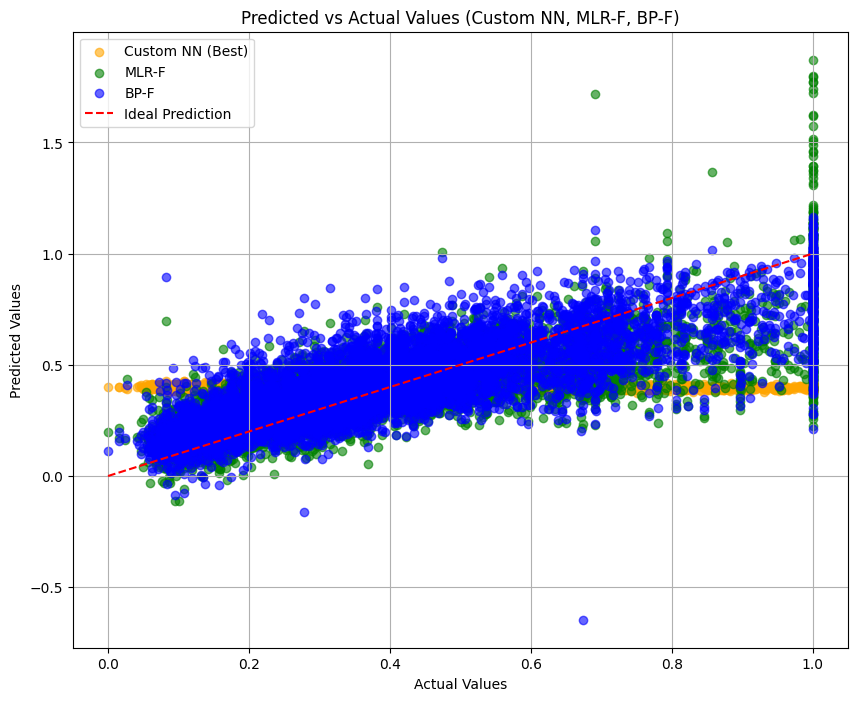

In [ ]:
# Part 3.2: Model Result Comparison

# Extract the best result from Part 3.1
best_set = results_df.loc[results_df["MSE_Mean"].idxmin()]
best_hyperparameters = hyperparameter_sets[int(best_set["Set"]) - 1]
best_result = {
    "hyperparameters": best_hyperparameters,
    "metrics": {
        "MSE": best_set["MSE_Mean"],
        "MAE": best_set["MAE_Mean"],
        "MAPE": best_set["MAPE_Mean"]
    }
}
print("Best Hyperparameters from Part 3.1:", best_result["hyperparameters"])
print("Best Metrics from Part 3.1:", best_result["metrics"])

# Use best metrics directly from Part 3.1
mse_nn = best_result["metrics"]["MSE"]
mae_nn = best_result["metrics"]["MAE"]
mape_nn = best_result["metrics"]["MAPE"]

# --- Evaluate Multi-Linear Regression (MLR-F) ---
print("Evaluating Multi-Linear Regression (MLR-F)...")


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


y_train_log = np.log1p(y_train)  # Apply log transformation
y_val_log = np.log1p(y_val)

# Train MLR-F on Transformed Target
mlr_model = LinearRegression()
mlr_model.fit(X_train_scaled, y_train_log)
mlr_predictions_log = mlr_model.predict(X_val_scaled)

# Reverse Log Transformation for Predictions
mlr_predictions = np.expm1(mlr_predictions_log)

# Calculate Metrics for MLR-F
mse_mlr = mean_squared_error(y_val, mlr_predictions)
mae_mlr = mean_absolute_error(y_val, mlr_predictions)

# Adjusted MAPE (Excluding Near-Zero Values)
def adjusted_mape(y_true, y_pred):
    mask = y_true > 1e-10
    y_true, y_pred = y_true[mask], y_pred[mask]
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_mlr = adjusted_mape(y_val, mlr_predictions)
print(f"MLR-F Results After Adjustment - MSE: {mse_mlr:.4f}, MAE: {mae_mlr:.4f}, MAPE: {mape_mlr:.4f}")

# --- Evaluate Pre-Built Neural Network (BP-F) ---
print("Evaluating Pre-Built Neural Network (BP-F)...")
bp_model = MLPRegressor(
    hidden_layer_sizes=best_hyperparameters["layers"][1:-1],  # Exclude input/output layers
    max_iter=200,
    random_state=42,
    activation="relu"  # Using ReLU for BP-F
)
bp_model.fit(X_train_scaled, y_train.ravel())
bp_predictions = bp_model.predict(X_val_scaled)

# Metrics for BP-F
mse_bp = mean_squared_error(y_val, bp_predictions)
mae_bp = mean_absolute_error(y_val, bp_predictions)
mape_bp = mean_absolute_percentage_error(y_val.ravel(), bp_predictions.ravel())
print(f"BP-F Results - MSE: {mse_bp:.4f}, MAE: {mae_bp:.4f}, MAPE: {mape_bp:.4f}")

# --- Create Comparison Table ---
comparison_df = pd.DataFrame({
    "Model": ["Custom NN (Best)", "MLR-F", "BP-F"],
    "MSE": [mse_nn, mse_mlr, mse_bp],
    "MAE": [mae_nn, mae_mlr, mae_bp],
    "MAPE": [mape_nn, mape_mlr, mape_bp]
})

print("\nComparison of Models:")
print(comparison_df)

# Scatter Plot for Predictions vs Actual Values (MLR-F and BP-F)
plt.figure(figsize=(10, 8))
# Plot Custom Neural Network (BP) Predictions
custom_nn_predictions = nn_test.predict(X_val_scaled)  # Predictions from your custom NN
plt.scatter(y_val, custom_nn_predictions, alpha=0.6, label="Custom NN (Best)", color="red")
plt.scatter(y_val, mlr_predictions, alpha=0.6, label="MLR-F", color="green")
plt.scatter(y_val, bp_predictions, alpha=0.6, label="BP-F", color="blue")
plt.plot(
    [y_val.min(), y_val.max()],
    [y_val.min(), y_val.max()],
    color="red",
    linestyle="--",
    label="Ideal Prediction"
)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values (Custom NN, MLR-F, BP-F)")
plt.legend()
plt.grid(True)
plt.show()
